# Quantifying muscle fatigue from EMG recordings

### Noel Isaías Plascencia Díaz<sup>1</sup>, Mitsui Myrna Salgado Saito<sup>2</sup>, Ana Daniela del Río Pulido<sup>3</sup>, and Erin C. McKiernan<sup>4</sup>

<sup>1</sup> Licenciatura en Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>2</sup> Licenciatura en Ciencias de la Tierra, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>3</sup> Licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>4</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>

## Overview

The objective of this data analysis practical is to learn how to quantify muscle fatigue from 
EMG recordings. The recordings to be analyzed can be found in our GitHub repository (https://github.com/emckiernan/electrophys). Before carrying out this analysis practical, students should first do the 'Graphing and exploring EMG data' and 'Filtering and analyzing EMG data' practicals from this series.

## Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules for plotting figures. We include commands to view plots in the notebook, and to create figures with good resolution and large labels.

In [256]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting module 
import matplotlib.pyplot as plt 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20 # fontsize for figure titles
plt.rcParams['font.size'] = 16 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting

Next, we import the necesssary modules and features to perform extract data, perform analysis, etc.

In [119]:
# import modules
import math
import numpy as np
import os
import pandas as pd
import scipy as sc
from scipy import signal
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, filtfilt
import wave

To analyze recordings, we first define a function that will allow us to quickly run the basic data extraction, visualization, and signal processing. This is the same function we defined in the 'Filtering and analyzing EMG data' practical.

In [120]:
def processEMG(file,graph):
    # open .wav file by specifying the path and filename
    record = wave.open(file)
    # extract number of channels, sample rate, data
    numChannels = record.getnchannels() # number of channels
    N = record.getnframes() # humber of frames
    sampleRate = record.getframerate() # sampling rate
    # extract data from the .wav file
    dstr = record.readframes(N * numChannels)
    waveData = np.frombuffer(dstr, np.int16)
    # calculate time window
    timeEMG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData))
    # calculate frequency
    freq = 1/np.mean(np.diff(timeEMG))
    # band-pass Butterworth filter at 10-400Hz
    b, a = butter(2, ([10, 400]/(freq/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    # rectify filtered EMG signal
    absSignal = np.absolute(dataf)
    timeAbs=np.linspace(0, len(absSignal)/sampleRate, num=len(absSignal))
    # low-pass Butterworth filter for envelope detection
    lowp = 8
    sfreq = sampleRate
    low_pass = lowp/sfreq
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, absSignal)
    # save relevant data in array
    xx={'sampleRate':sampleRate,\
        'waveData':waveData,\
        'timeEMG':timeEMG,\
        'freq':freq,\
        'dataf':dataf,\
        'absSignal':absSignal,\
        'timeAbs':timeAbs,\
        'datafrle':datafrle       
        }   
    # plot EMG 
    if graph:
        
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (20,15))

        # plot filtered data
        ax1.plot(timeEMG,dataf, 'b')
        ax1.set_title('Raw data', fontsize=20)
        ax1.set_xlim(0,max(timeEMG))
        #ax1.set_ylim(-8000,4000)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('voltage ($\mu$V)')
        
        # plot rectified data with envelope
        ax2.plot(timeAbs,datafrle*3, 'r', linewidth=2.5) # multiply envelope to see data fit
        ax2.plot(timeAbs,absSignal, 'b', alpha=0.4)
        ax2.set_title('Rectified EMG with envelope', fontsize=20)
        ax2.set_xlim(0,max(timeEMG))
        ax2.set_xlabel('time (s)')
        ax2.set_ylabel('voltage ($\mu$V)')
        
        # plot envelope with potential threshold
        ax3.plot(timeAbs,datafrle, 'b')
        #plt.axhline(y=200, color='k',linewidth=2.0, linestyle='--') # potential threshold 
        ax3.set_title('Enveloped EMG', fontsize=20)
        ax3.set_xlim(0,max(timeEMG))
        #ax3.set_ylim(0,1200)
        ax3.set_xlabel('time (s)')

        # spacing between subplots
        plt.tight_layout(pad=3.0)
    
    return xx

## Muscle fatigue over a single trial

As muscles contract, they also fatigue, especially if a significant effort is exerted, or if the contraction is prolonged. There are several ways we can visualize and quantify fatigue. 

### Changes in EMG signal amplitude with fatigue
The following recording was obtained from the bicep muscle while performing a sustained concentric contraction, i.e. holding a weight with the arm bent at 90 degrees for 50 seconds (contraction starts around t=5s and ends at t=55s). 

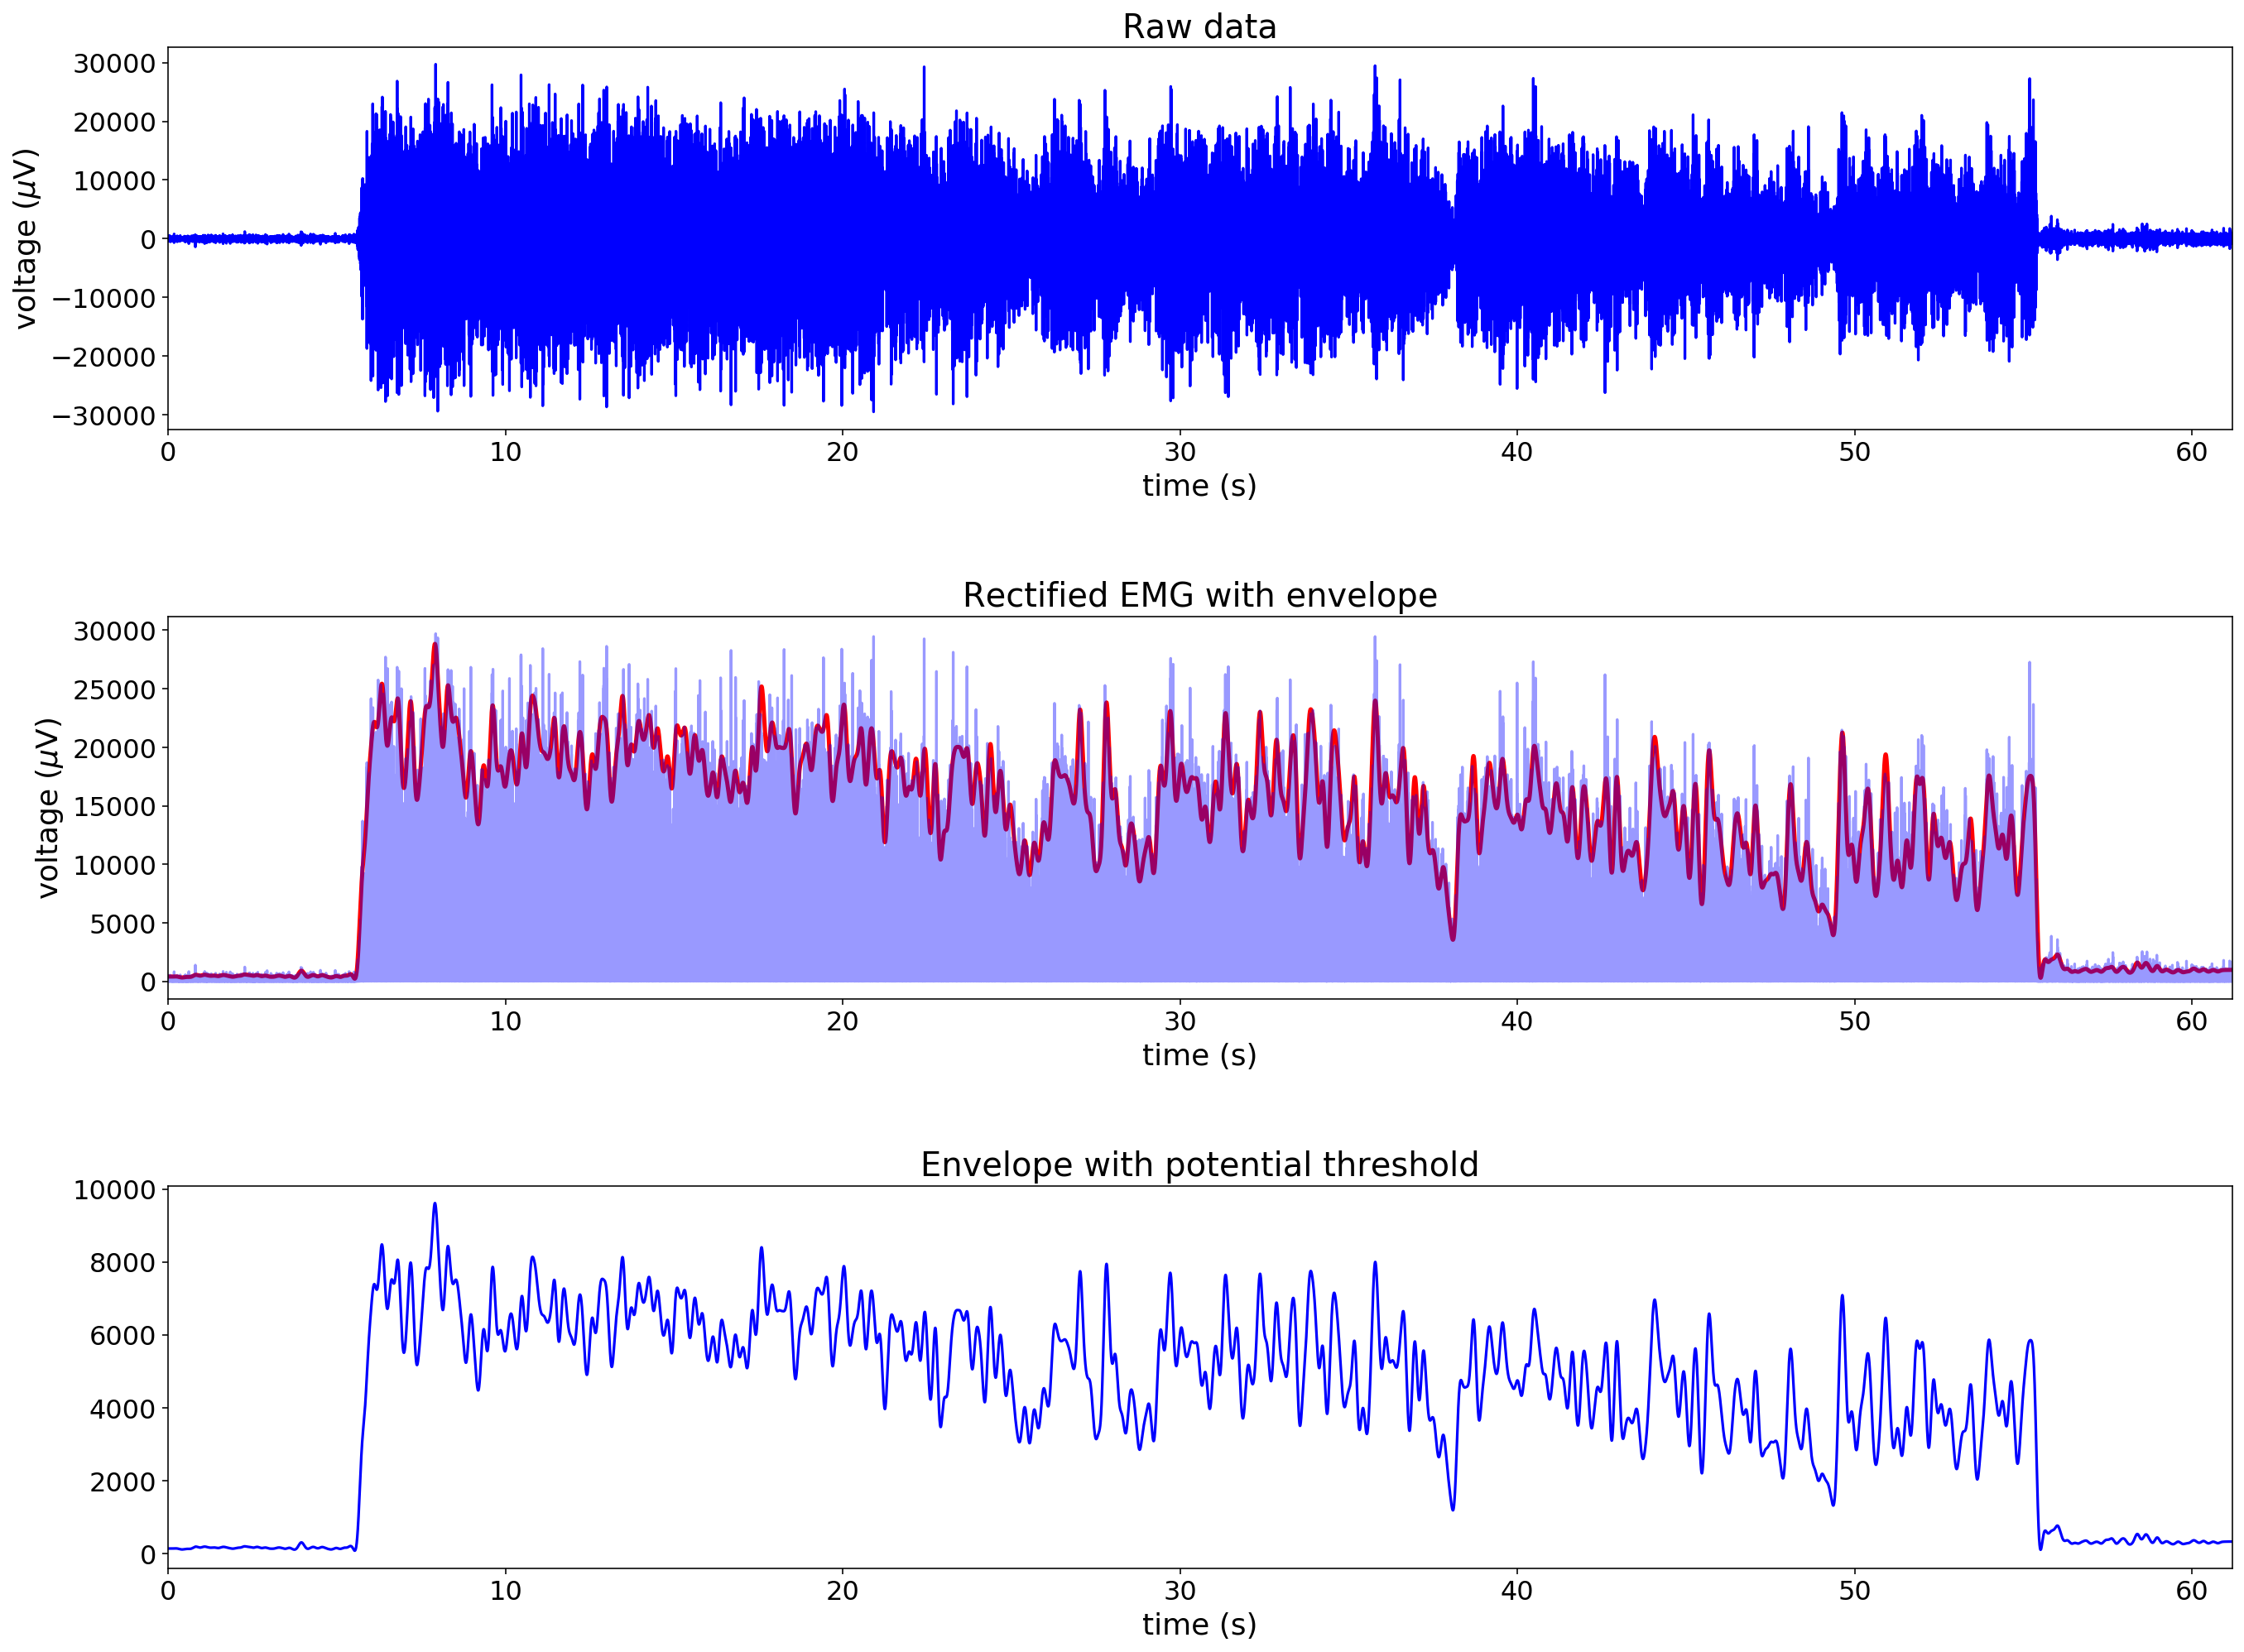

In [52]:
xx=processEMG(file='../data/S3/concentric/S3_EMG_concentric_trial0.wav',graph=1)

As we can see in the above recording, the amplitude of the signal decreases as the recording progresses and the muscle presumably fatigues. One way to quantify this is to bin the data and find the maximum amplitude of the signal within each bin. For ease, we first divide the data into 1 second bins. 

In [59]:
# calculate number of 1 second bins in the recording; 'floor' to expresses number as integer
nbins = math.floor(len(xx['waveData'])/xx['sampleRate'])
print('The recording has %d bins of 1 second duration.' % (nbins))

# function to create bins, adapted from https://www.python-course.eu/pandas_python_binning.php
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound,lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

# run function to create bins
secBins = createBins(0,xx['sampleRate'],nbins)

The recording has 61 bins of 1 second duration.


Next, we iterate over the bins, calculating the maximum amplitude for each bin and plot the results. 

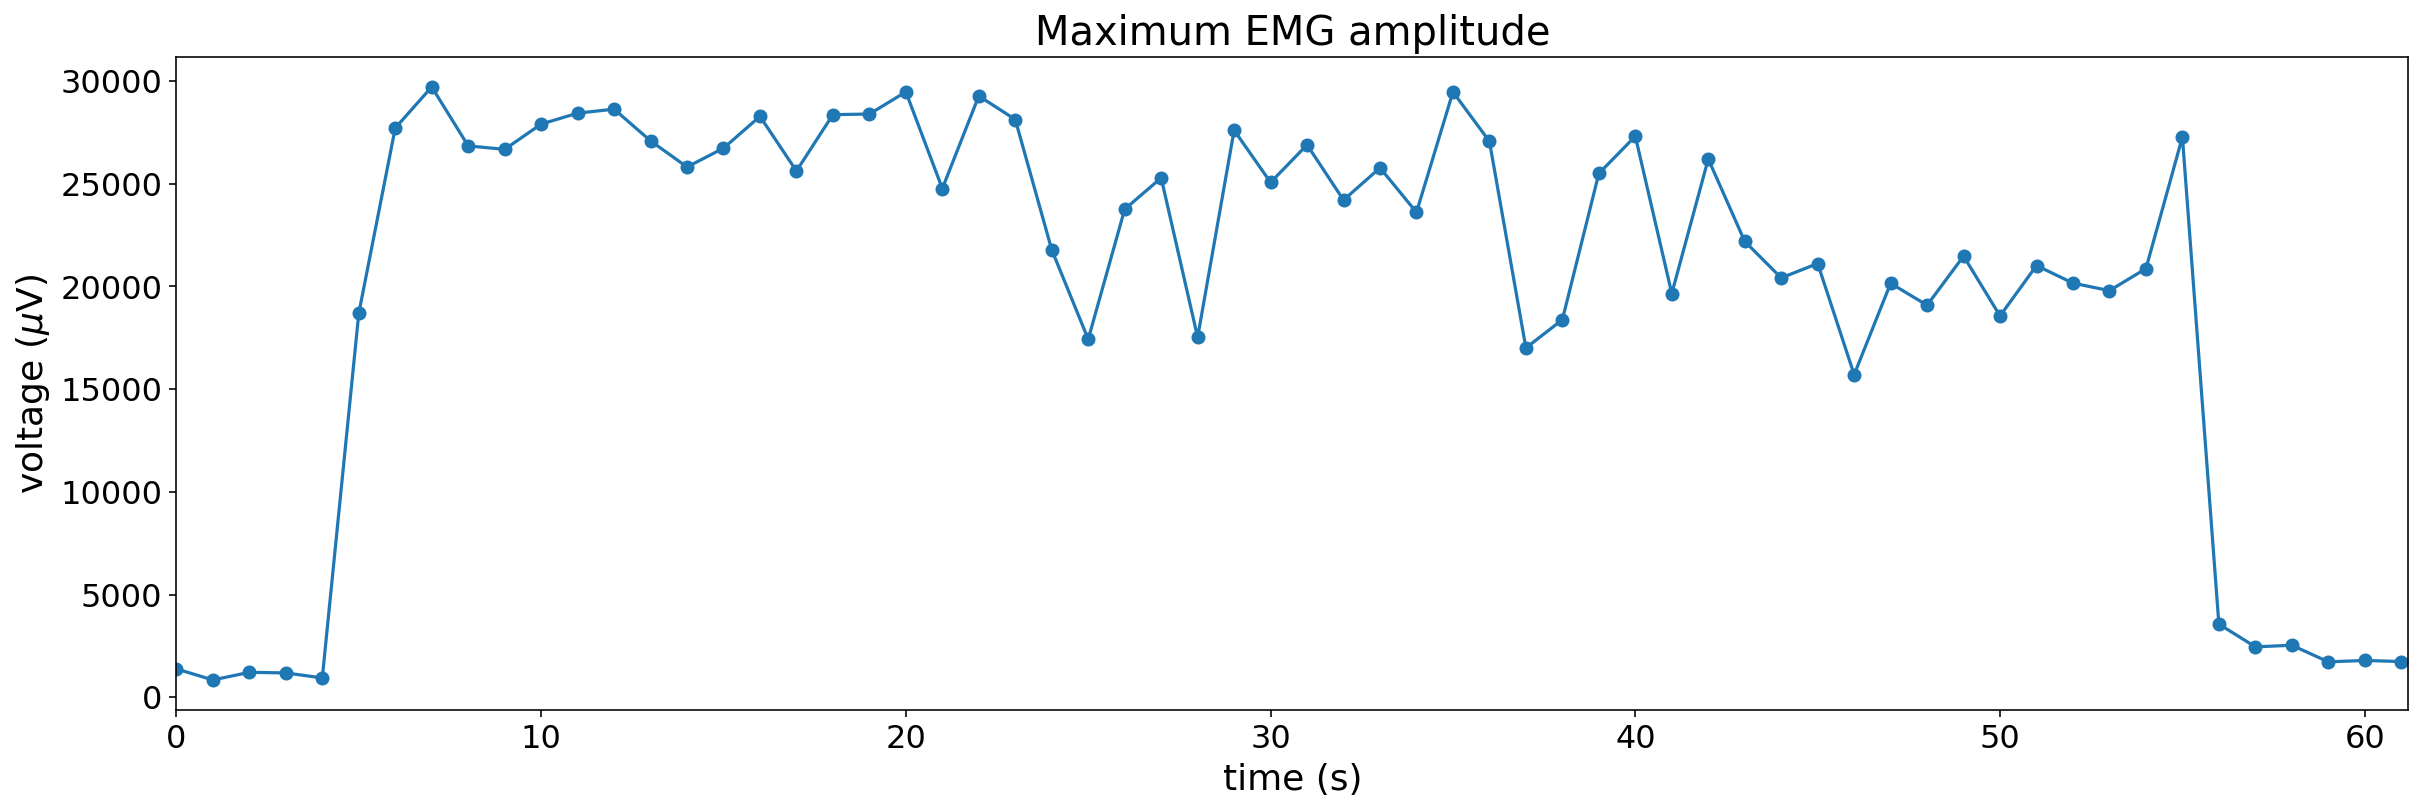

In [56]:
# calculate max amplitude over the bins
x = secBins
y = xx['absSignal']
maxamps = []

for n in range(0,len(x)):
    maxAmp=y[min(x[n]):max(x[n])].max()
    maxamps.append(maxAmp)

# plot results    
plt.figure(figsize=(20,6))
plt.plot(maxamps,'o-')
plt.title('Maximum EMG amplitude')
plt.xlabel('time (s)')
plt.xlim(0,max(xx['timeEMG']))
plt.ylabel(r'voltage ($\mu$V)');

The above graph shows that the maximum amplitude decreases slightly as the recording progresses. However, outliers make the trend a less clear than it might be. Instead, we can also iterate over the bins and calculate the mean amplitude to see if that gives us a clearer picture of the decrease due to fatigue.

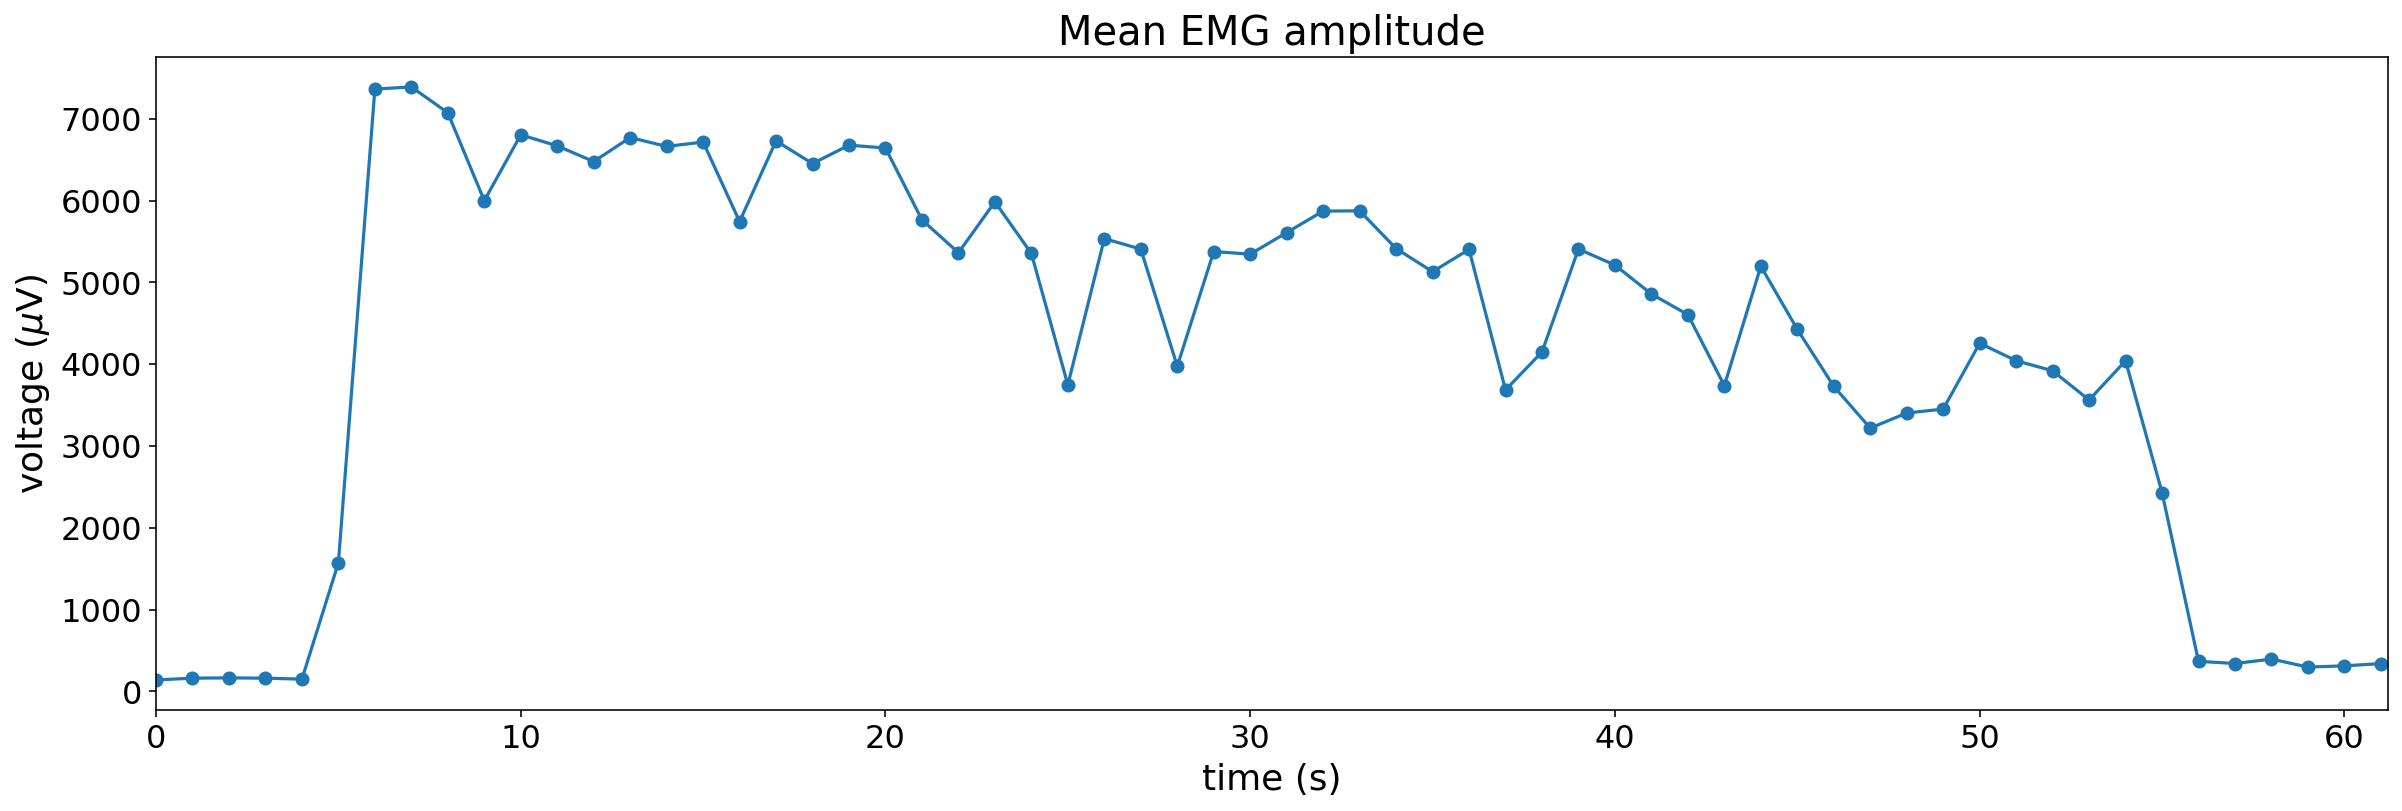

In [57]:
# calculate mean amplitude over bins
meanamps = []
for n in range(0,len(x)):
    meanAmp=y[min(x[n]):max(x[n])].mean()
    meanamps.append(meanAmp)

# plot results
plt.figure(figsize=(20,6))
plt.plot(meanamps,'o-')
plt.title('Mean EMG amplitude')
plt.xlabel('time (s)')
plt.xlim(0,max(xx['timeEMG']))
plt.ylabel(r'voltage ($\mu$V)');

In this case, the trend is much clearer and we can see how the mean amplitude decreases throughout the recording, indicating muscle fatigue. One crude but effective way to calculate the size of the decrease is by taking the difference between the peak mean amplitudes at the beginning (bin 6) and end (bin 54) of the muscle activity.

In [58]:
ampChange = meanamps[6] - meanamps[54]
print(ampChange)

3321.231964621004


The above calculation shows an over 3,000 microvolt decrease in amplitude over the course of the recording.

We can also calculate the variance over the bins, which shows a similar decrease, also indicating fatigue.

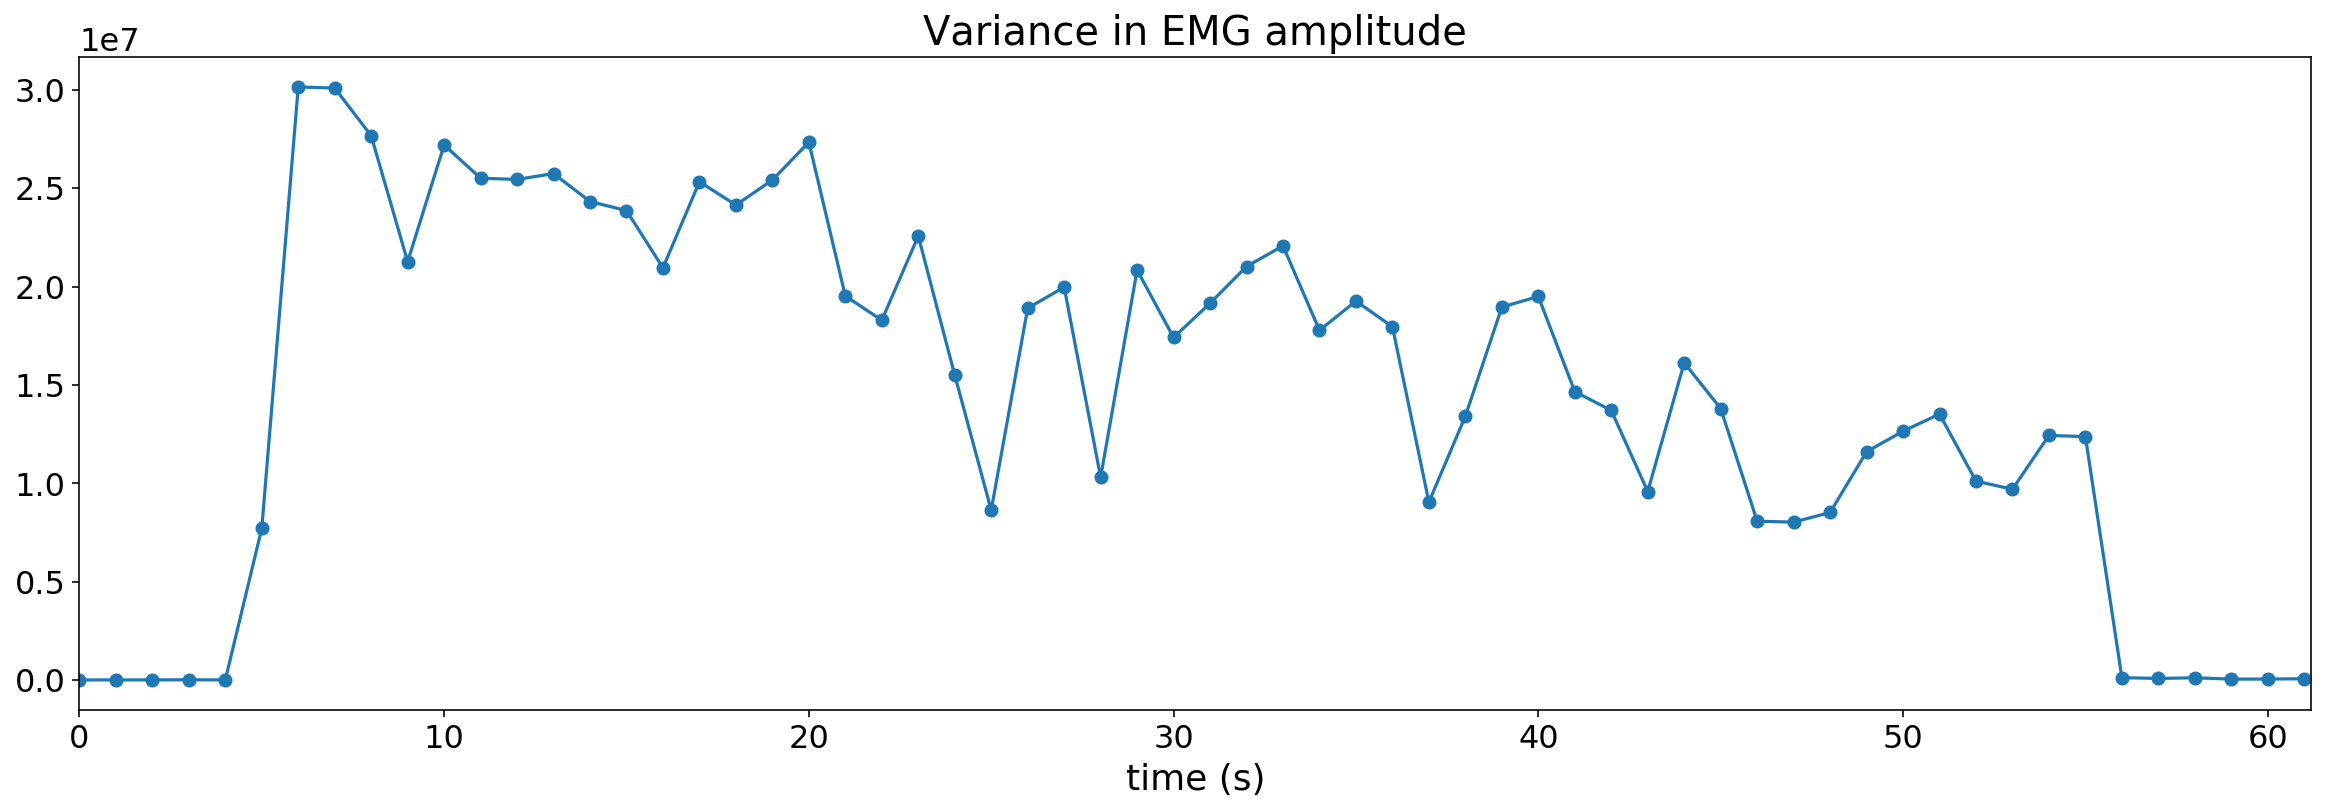

In [63]:
varamps = []
for n in range(0,len(x)):
    varAmp=y[min(x[n]):max(x[n])].var()
    varamps.append(varAmp)

# plot results
plt.figure(figsize=(20,6))
plt.plot(varamps,'o-')
plt.title('Variance in EMG amplitude')
plt.xlabel('time (s)')
plt.xlim(0,max(xx['timeEMG']));

## Changes in EMG frequency with fatigue

Muscle fatigue is also marked by a decrease in the frequency of the EMG signal, which can result from both a decrease in the firing rate of individual motor units and a decrease in the total number of active motor units. For ease of analysis, we first shorten the EMG signal by removing the baseline activty before and after the muscle contraction. In other words, the shortened EMG has only the activity during the contraction.

In [92]:
# shorten EMG to leave only contraction activity; run on filtered (non-rectified) data
def shortEMG(signal, threshold):
    difSignal = np.diff(signal)
    startind=np.where(difSignal>threshold)[0][0]
    endind=np.where(difSignal[::-1]>threshold)[0][0]
    endind=len(difSignal)-endind
    return(signal[startind:endind])

workdata = shortEMG(xx['dataf'],150)

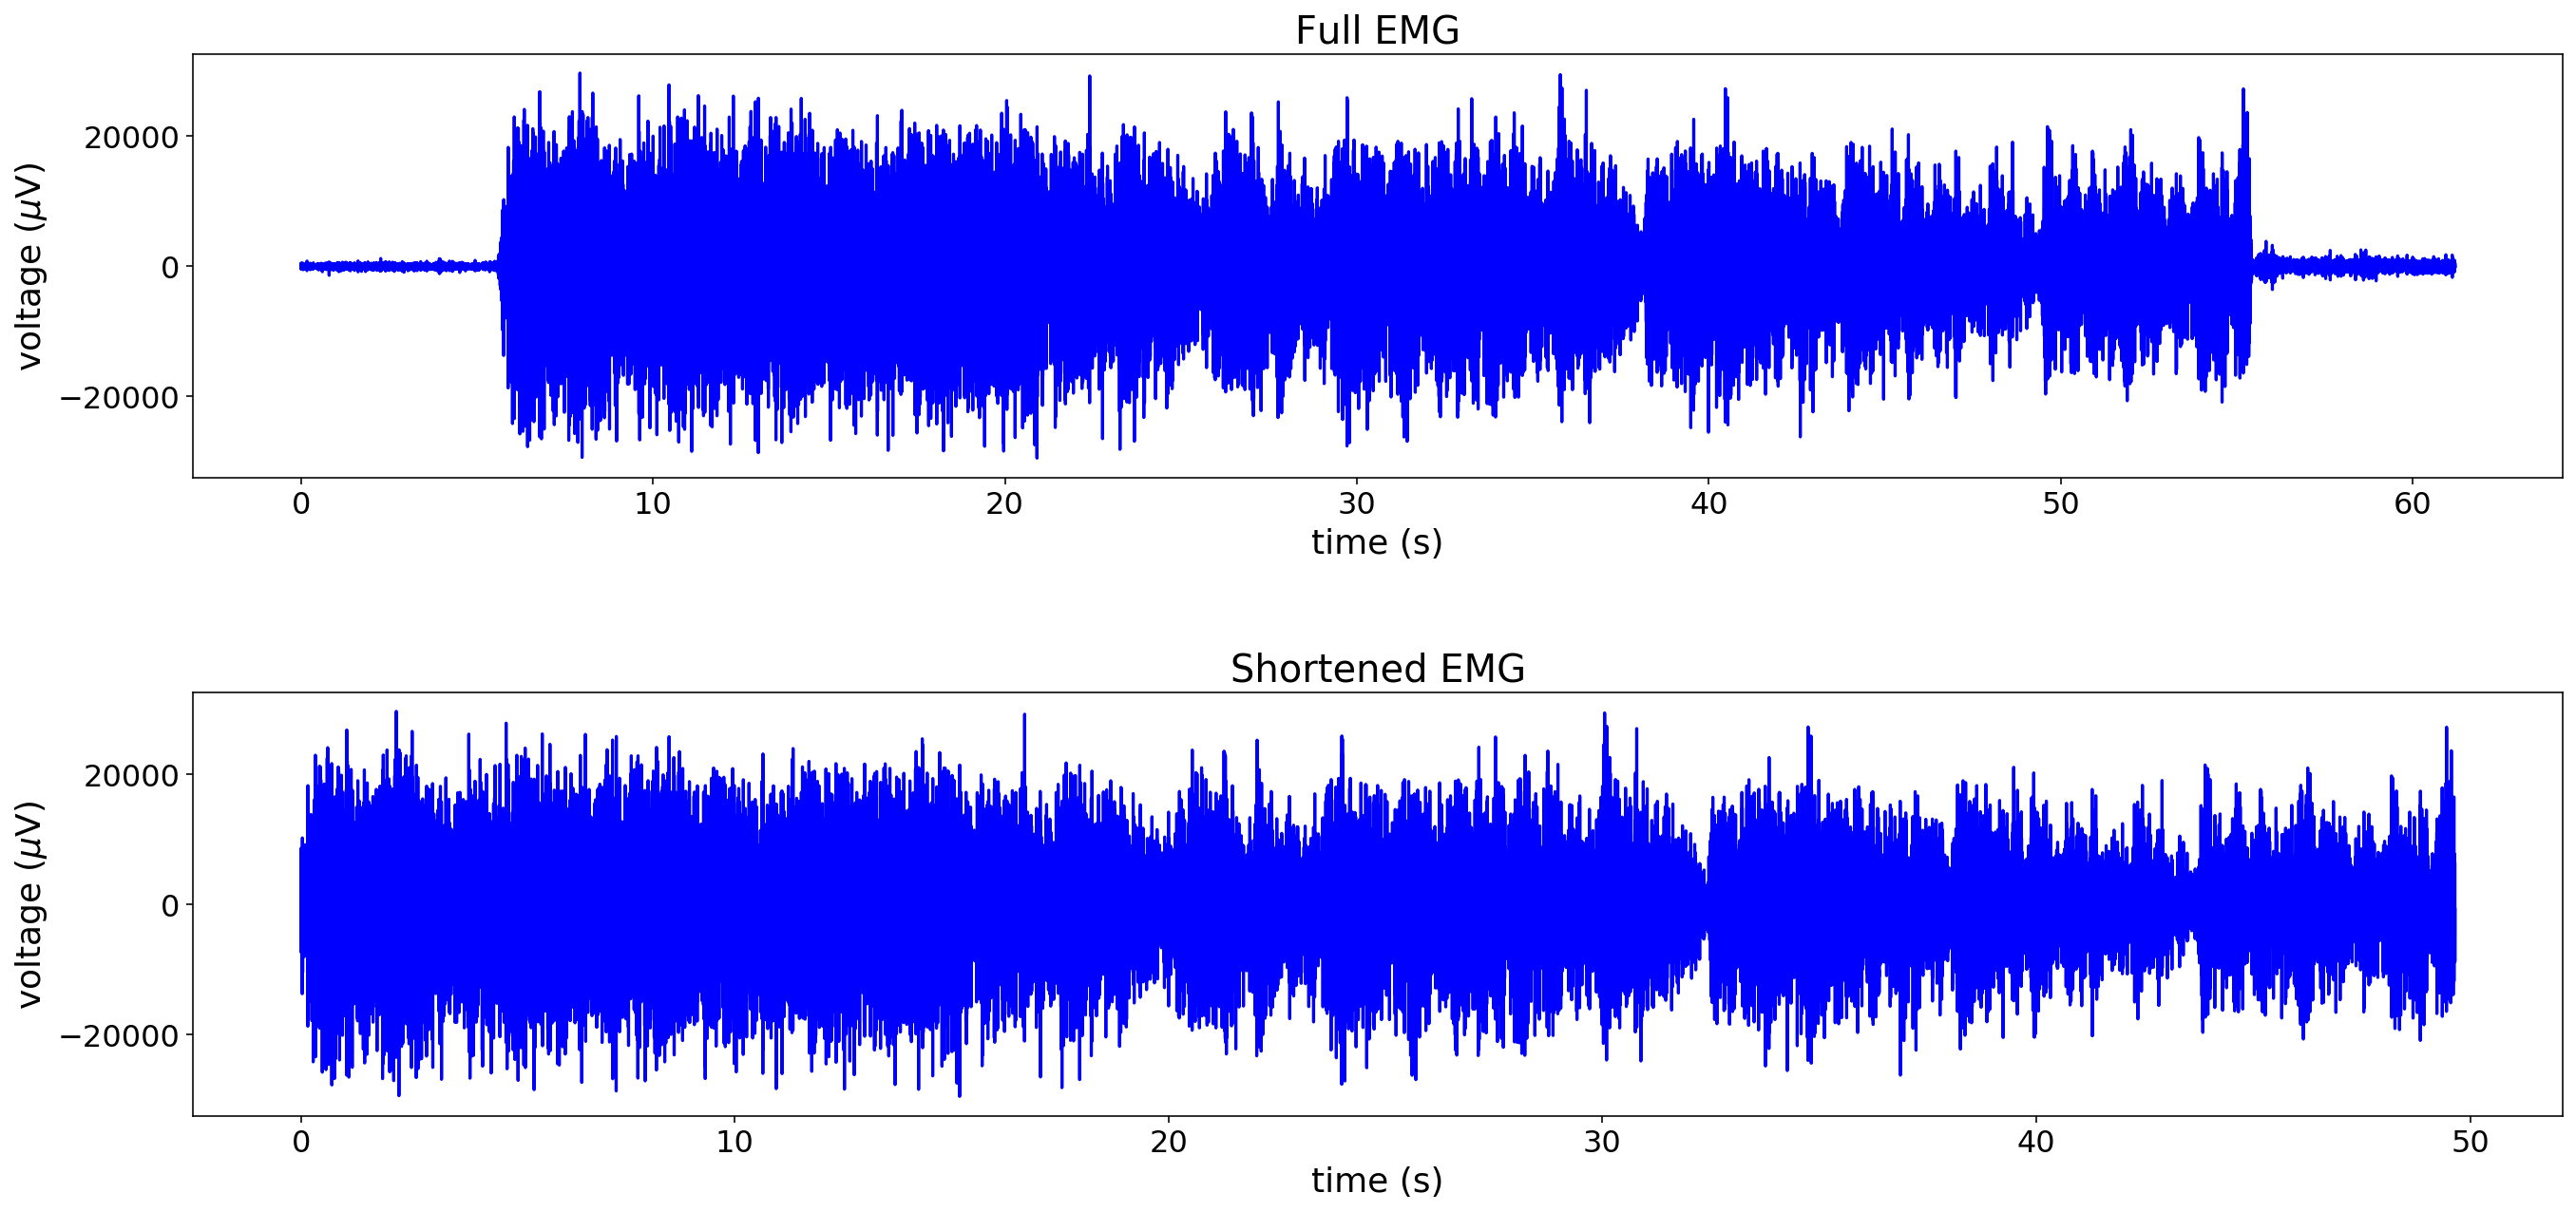

In [93]:
# plot results to compare original to shortened EMG
fig, (ax1,ax2) = plt.subplots(2,1,sharex=False,sharey=False,figsize = (20,10))

# plot full EMG
ax1.plot(xx['timeEMG'],xx['dataf'],'b')
ax1.set_title('Full EMG')
ax1.set_ylabel('voltage ($\mu$V)')
ax1.set_xlabel('time (s)')
#ax1.set_xlim(0,max(xx['timeEMG']))

# plot shortened EMG
ax2.plot(np.arange(0,len(workdata))/xx['sampleRate'],workdata,'b')
ax2.set_title('Shortened EMG')
ax2.set_ylabel(r'voltage ($\mu$V)')
ax2.set_xlabel('time (s)')
#ax1.set_xlim(0,max(xx['timeEMG']))

# spacing between subplots
plt.tight_layout(pad=3.0)

Next, we divide the EMG data into windows and define that as the 'workdata' which we will run through the frequency analysis.

In [94]:
def windows(data,npoints,step):
    datapts = np.size(data)
    anchorpts = np.arange(0,datapts-npoints,step)
    noverlap = len(anchorpts) 
    ovData = [data[anchorpts[i]:anchorpts[i]+npoints] for i in range(0,noverlap)]    
    return(ovData)

windowedEMG = windows(workdata,xx['sampleRate'],xx['sampleRate'])

Now, we calculate the Power Spectral Density (PSD) using a Fourier transform.

In [95]:
# function for calculating Power Spectral Density (PSD)
# adapted from https://stackoverflow.com/questions/1523814/
# units-of-a-fourier-transform-fft-when-doing-spectral-analysis-of-a-signal/1524535

def PSD(data):
    ps = np.abs(np.fft.fft(data))**2
    timeStep = 1 / xx['sampleRate']
    freqs = np.fft.fftfreq(data.size, timeStep)
    idx = np.argsort(freqs)
    goodinds = np.where(freqs[idx]>0)[0]
    F = freqs[idx][goodinds]
    P = ps[idx][goodinds]
    return([F,P])

F,P = PSD(windowedEMG[0])

We plot the results, showing the EMG signal in the first bin (bin 0), the PSD for that bin, and the log of the PSD for the same bin.

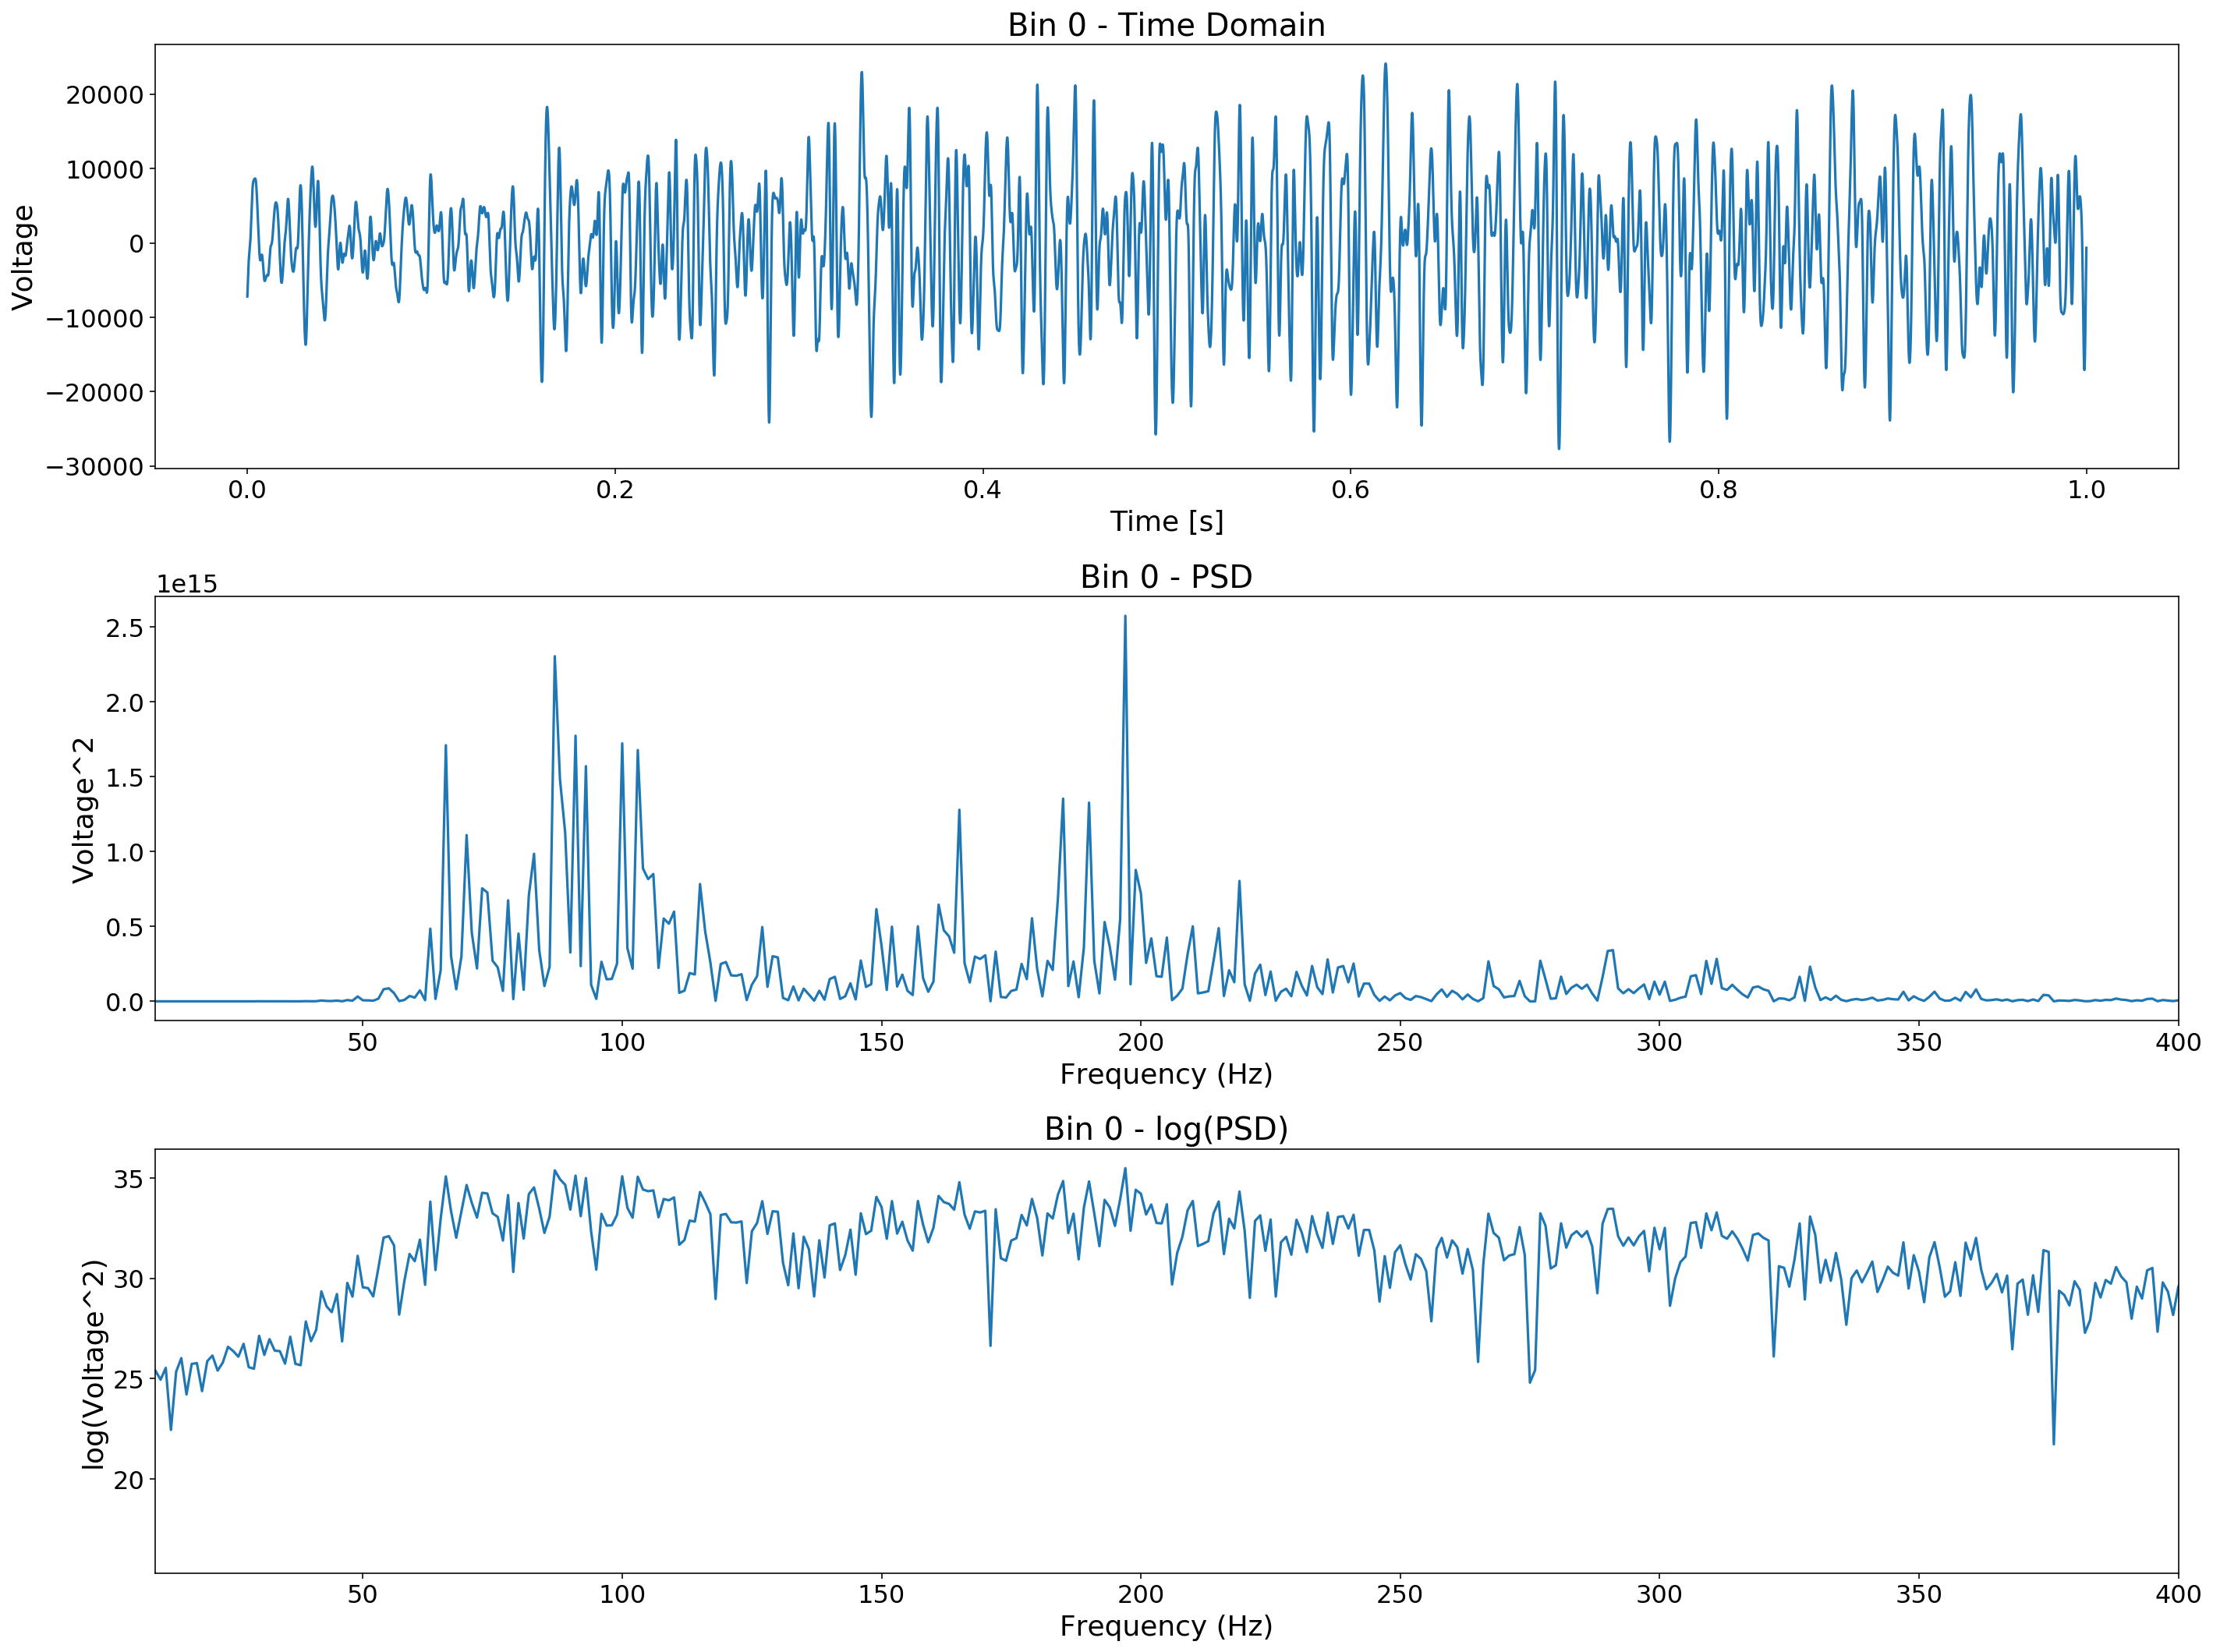

In [98]:
fig = plt.figure(figsize=(20,15))

# EMG signal
ax = plt.subplot(311)
ax.plot(np.arange(0,xx['sampleRate'])/xx['sampleRate'],windowedEMG[0])
plt.xlabel('Time [s]')
plt.ylabel('Voltage')
plt.title('Bin 0 - Time Domain')

# PSD
ax = plt.subplot(312)
ax.plot(F,P)
plt.xlim(10,400)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Voltage^2') 
plt.title('Bin 0 - PSD')

# log PSD
ax = plt.subplot(313)
ax.plot(F,np.log(P))
plt.xlim(10,400)
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(Voltage^2)') 
plt.title('Bin 0 - log(PSD)')

plt.tight_layout(pad=3.0)

The above plots show the frequency analysis for just the first bin. Now, to examine the effects of fatigue, we can compare the first bin, bin number 10, and the last bin of the recording to see how the PSD changes.

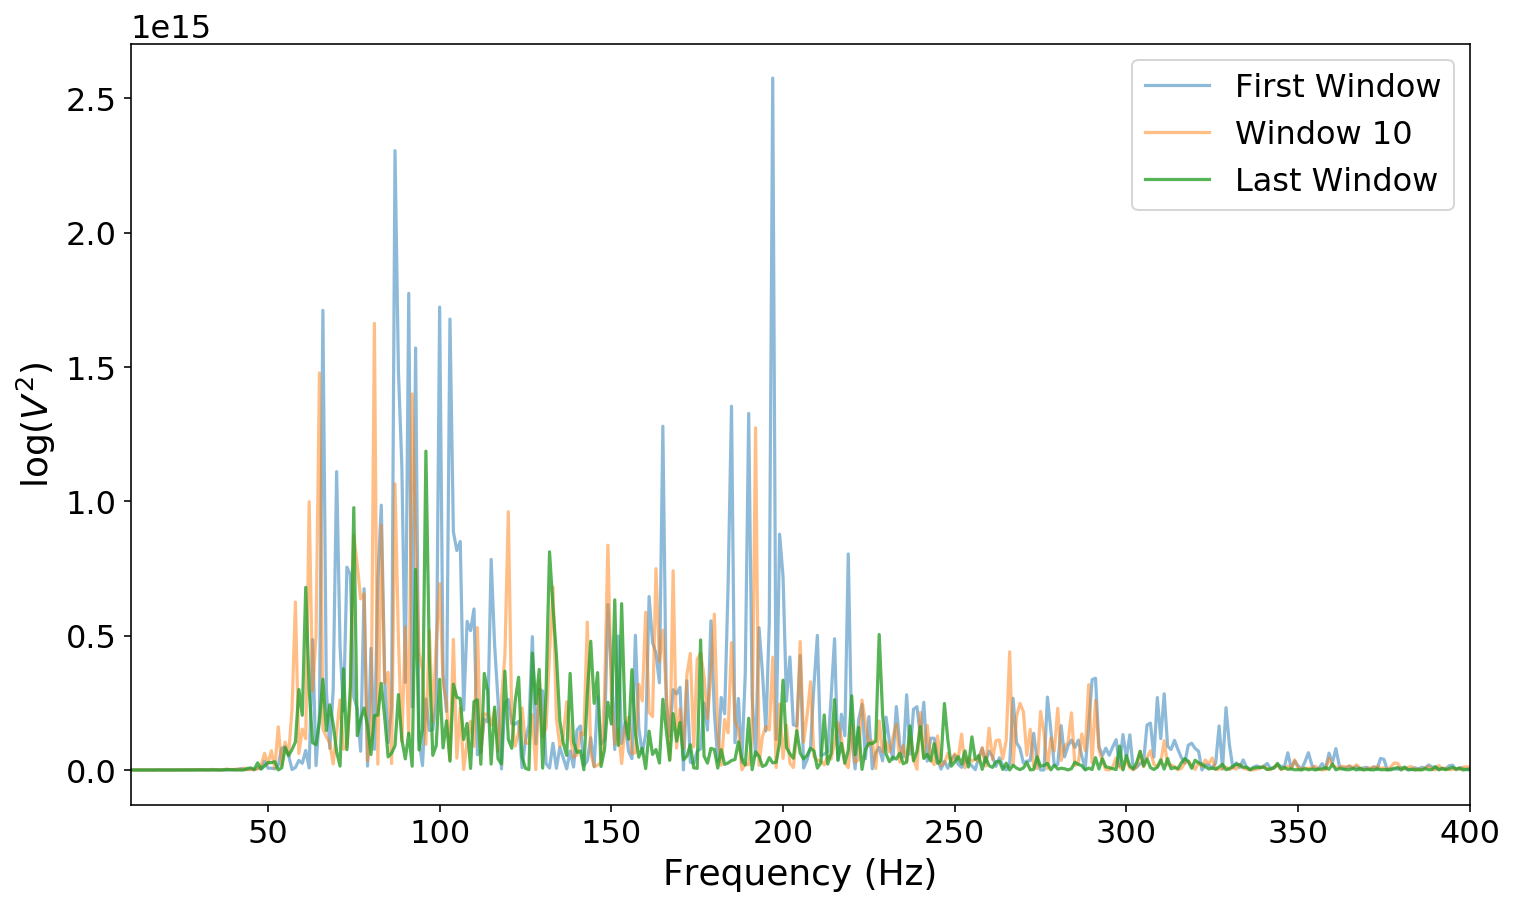

In [104]:
fig = plt.figure(figsize=(12,7))

ax = plt.subplot(111)
ax.plot(PSD(windowedEMG[0])[0],
        PSD(windowedEMG[0])[1],
        label='First Window',alpha=.5)

ax.plot(PSD(windowedEMG[10])[0],
        PSD(windowedEMG[10])[1],
        label='Window 10',alpha=.5)

ax.plot(PSD(windowedEMG[-1])[0],
        PSD(windowedEMG[-1])[1],
        label='Last Window',alpha=.8)

plt.xlim(10,400)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('log($V^2$)'); 

Using the PSD function, we can also calculate the mean and median power frequencies, which have been shown to change with muscle fatigue.

In [110]:
# mean power frequency
def meanPF(data):
    F,P = PSD(data)
    sumProd = sum([F[i]*P[i] for i in range(0,len(F))])
    sumPower = sum(P)
    meanPower = sumProd/sumPower    
    return(round(meanPower,5))

# median power frequency
def medianPF(data):
    F,P = PSD(data)
    medianPower = sum(P)/2   
    return(round(medianPower,5))

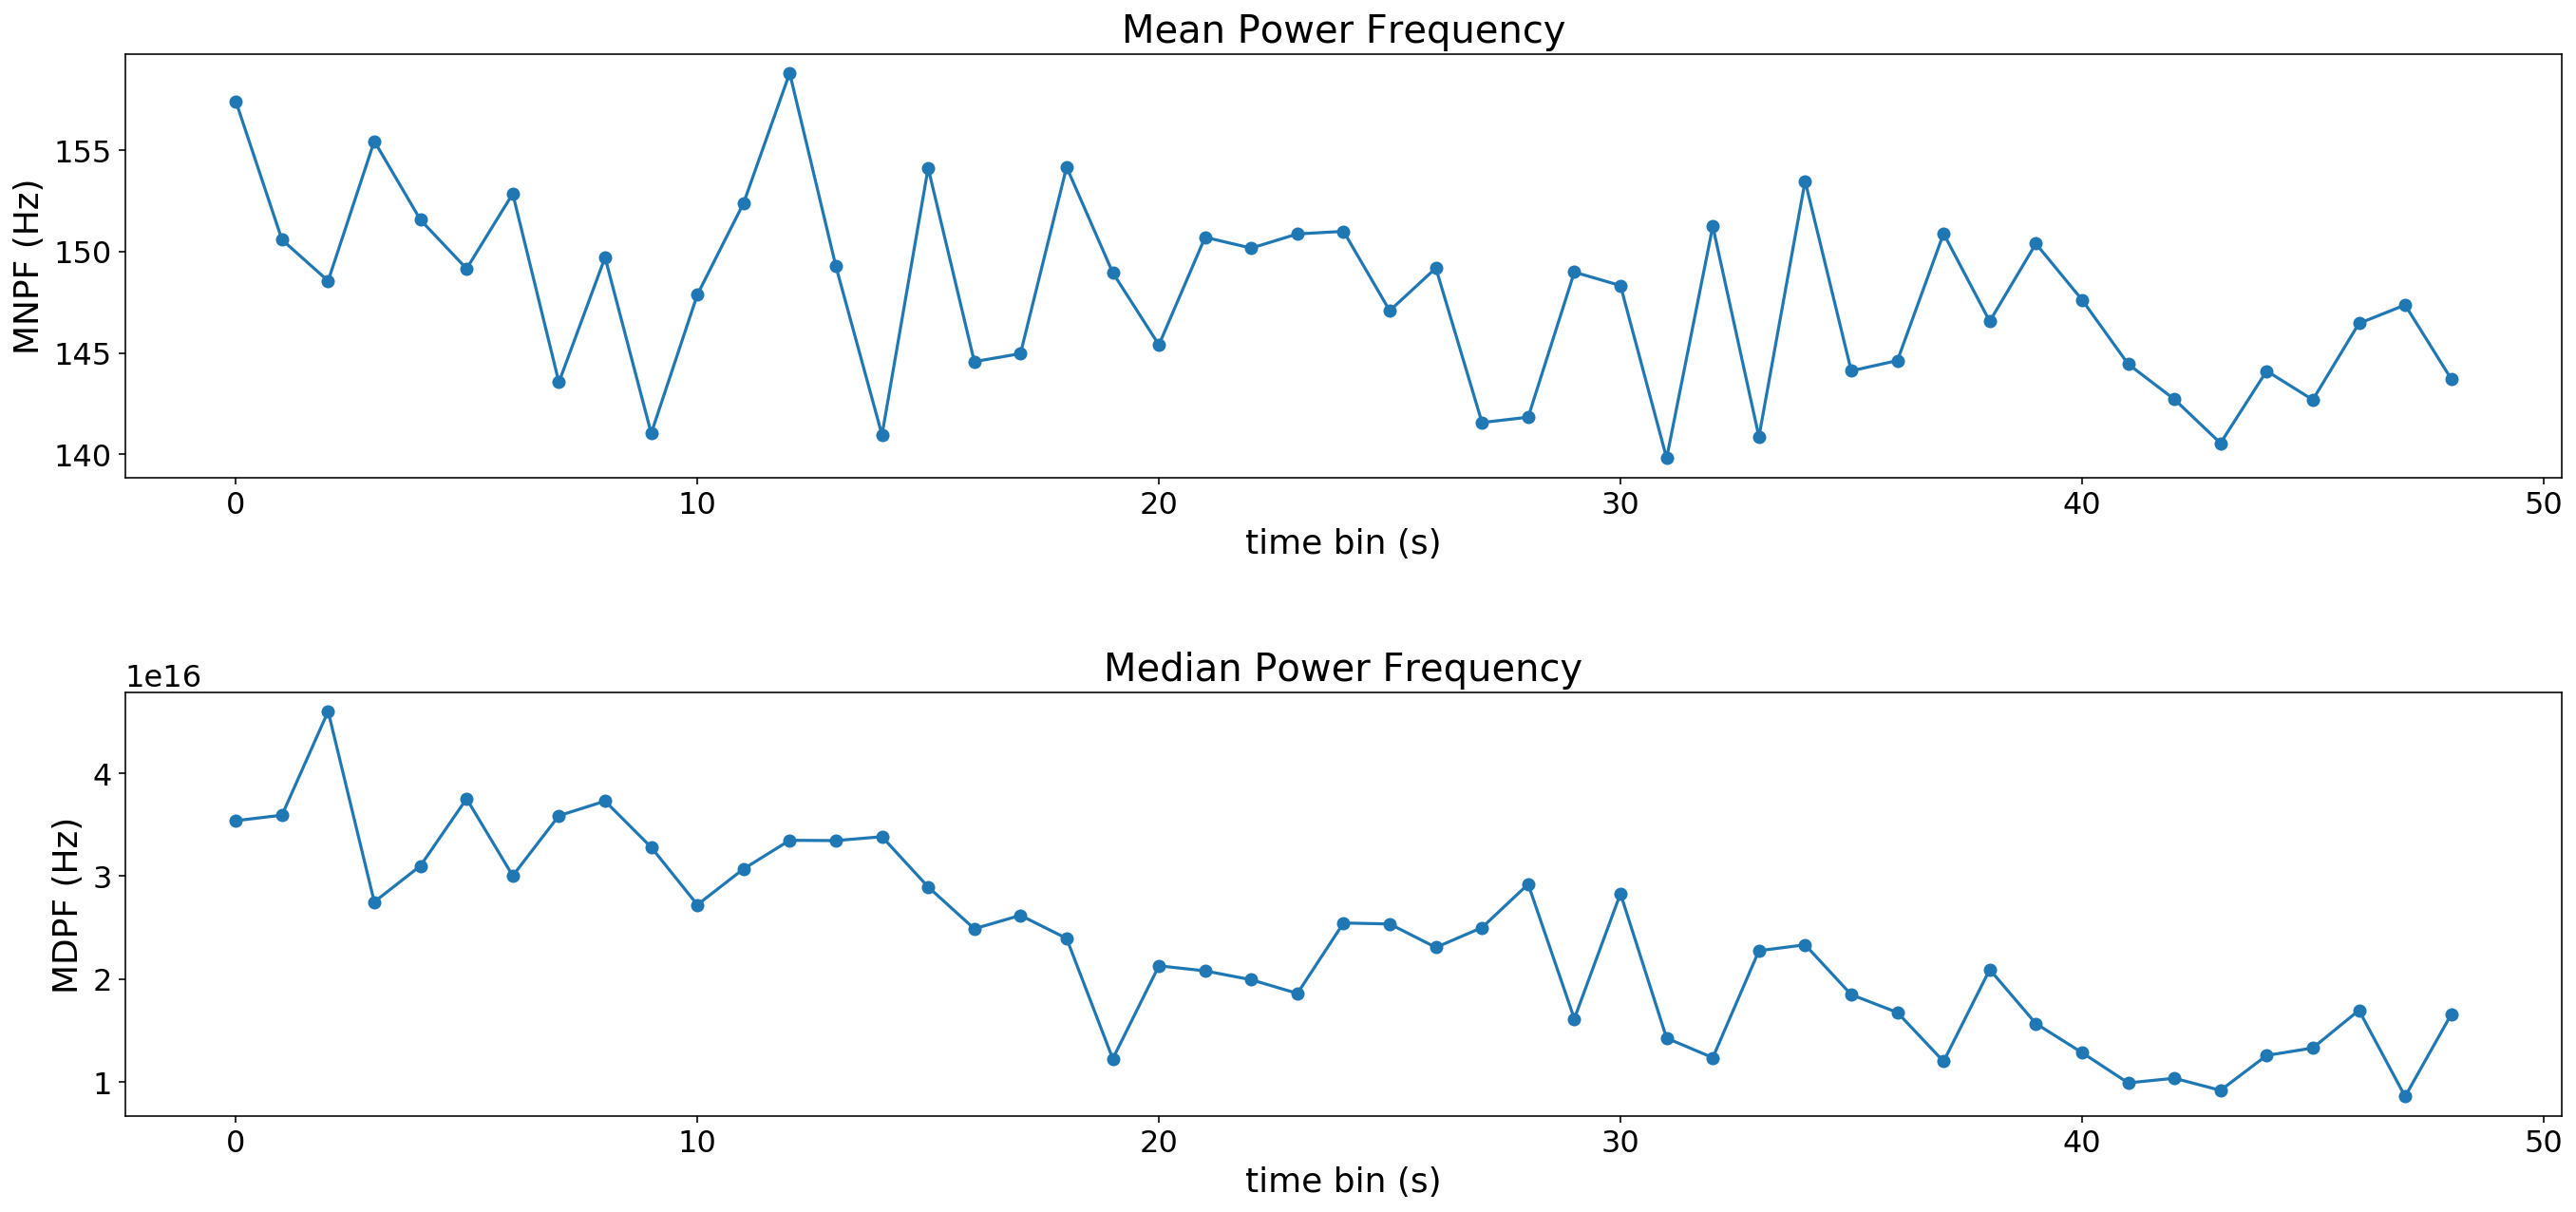

In [114]:
MNPF = list(map(meanPF,windowedEMG))
MDPF = list(map(medianPF,windowedEMG))

fig, (ax1,ax2) = plt.subplots(2,1,sharex=False,sharey=False,figsize = (20,10))

ax1.plot(MNPF,'o-')
ax1.set_title('Mean Power Frequency')
ax1.set_ylabel('MNPF (Hz)')
ax1.set_xlabel('time bin (s)')

ax2.plot(MDPF,'o-')
ax2.set_title('Median Power Frequency')
plt.ylabel('MDPF (Hz)')
plt.xlabel('time bin (s)')

plt.tight_layout(pad=3.0)

Both measures show a decrease as the EMG recording progresses, indicating fatigue. However, the trend is clearer with the Median Power Frequency.

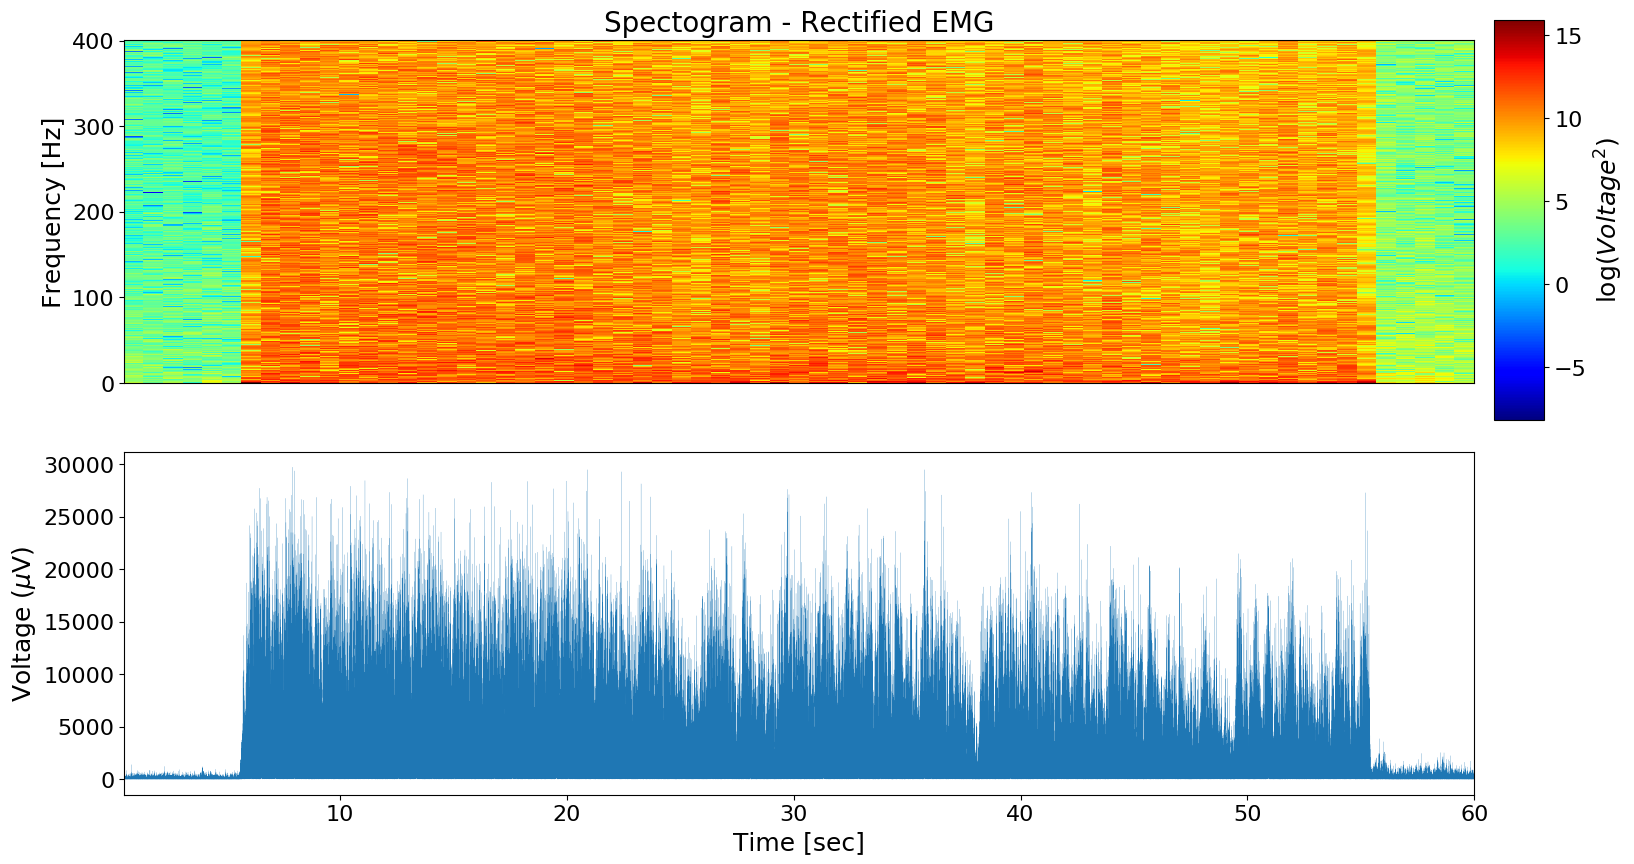

In [118]:
data = xx['absSignal']
f,t,sxx = sc.signal.spectrogram(data,xx['sampleRate'],nperseg=xx['sampleRate'],\
                                scaling='spectrum')
f = f[:401]
sxx = sxx[:401]

fig = plt.figure(figsize=(20,10),dpi=50)
ax1 = plt.subplot(211)
plt.pcolormesh(np.log(sxx),cmap='jet')
plt.xticks([])
plt.ylabel('Frequency [Hz]')
plt.title('Spectogram - Rectified EMG')

ax2 = plt.subplot(212)
plt.plot(np.arange(0,len(data))/xx['sampleRate'],data,lw=.1)
plt.ylabel('Voltage ($\mu$V)')
plt.xlabel('Time [sec]')
plt.xlim(t[0],t[-1])

# adding an independent axis for the colorbar:
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.81, .5, 0.025, 0.4])
plt.colorbar(label='log($Voltage^2$)',cax=cbar_ax,)

plt.draw()

## Muscle fatigue across trials

Muscles also fatigue with repeated contractions. We asked subjects to repeat the above exercise (holding a weight with the arm bent at 90 degrees for 50 seconds) for 10 trials with 60 seconds rest between each trial. Trial 0, analyzed above, is the first trial (i.e. before fatigue through repetition) and trial 9 is the last repetition, i.e. after fatigue.

There are several measures we could use to quantify fatigue. One is the **maximum amplitude** of the EMG signal. If repeated trials fatigue the muscle, then the maximum contraction subjects generate during trial 9 should be less than that generated during trial 0, and we will see a decrease in the maximum amplitude. Second, we can calculate the **root mean square (RMS)** of the signal, which should also decrease with fatigue. Finally, we calculate the **total area** of the envelope signal, i.e. the maximum of the cumulative sum, which should decrease as well. 

First, we run our analysis function on trials 0 and 9 for a given subject and graph the two recordings.

In [121]:
# specify files to be analyzed
EMGfiles = ['../data/S3/concentric/S3_EMG_concentric_trial0.wav',
            '../data/S3/concentric/S3_EMG_concentric_trial9.wav']

In [123]:
# create an empty array to store data
data = []
# iterate over each recording to analyze and graph
for record in EMGfiles:
    xx=processEMG(record,graph=0)
    data.append(xx)

Now, we calculate the maximum amplitude (maxamps), the maximum cumulative sum (maxsums), and RMS (rmss) for trials 0 and 9, and then generate bar graphs to compare each measure before and after fatigue.

In [124]:
# create empty arrays to hold measures
maxsums = []
maxamps = []
rmss = []

# for loop to iterate over recordings
for n in range(len(data)):
    # calculate the maximum amplitude 
    maxamp=max(data[n]['absSignal'])
    maxamps.append(maxamp)
    # calculate the cumulative sum 
    sumSignal = np.cumsum(data[n]['absSignal'])
    # calculate the max of the cumulative sum, i.e. the total area
    maxsum = max(sumSignal)
    maxsums.append(maxsum)
    # calculate RMS
    rms=np.sqrt(np.mean(data[n]['absSignal']**2))
    rmss.append(rms)

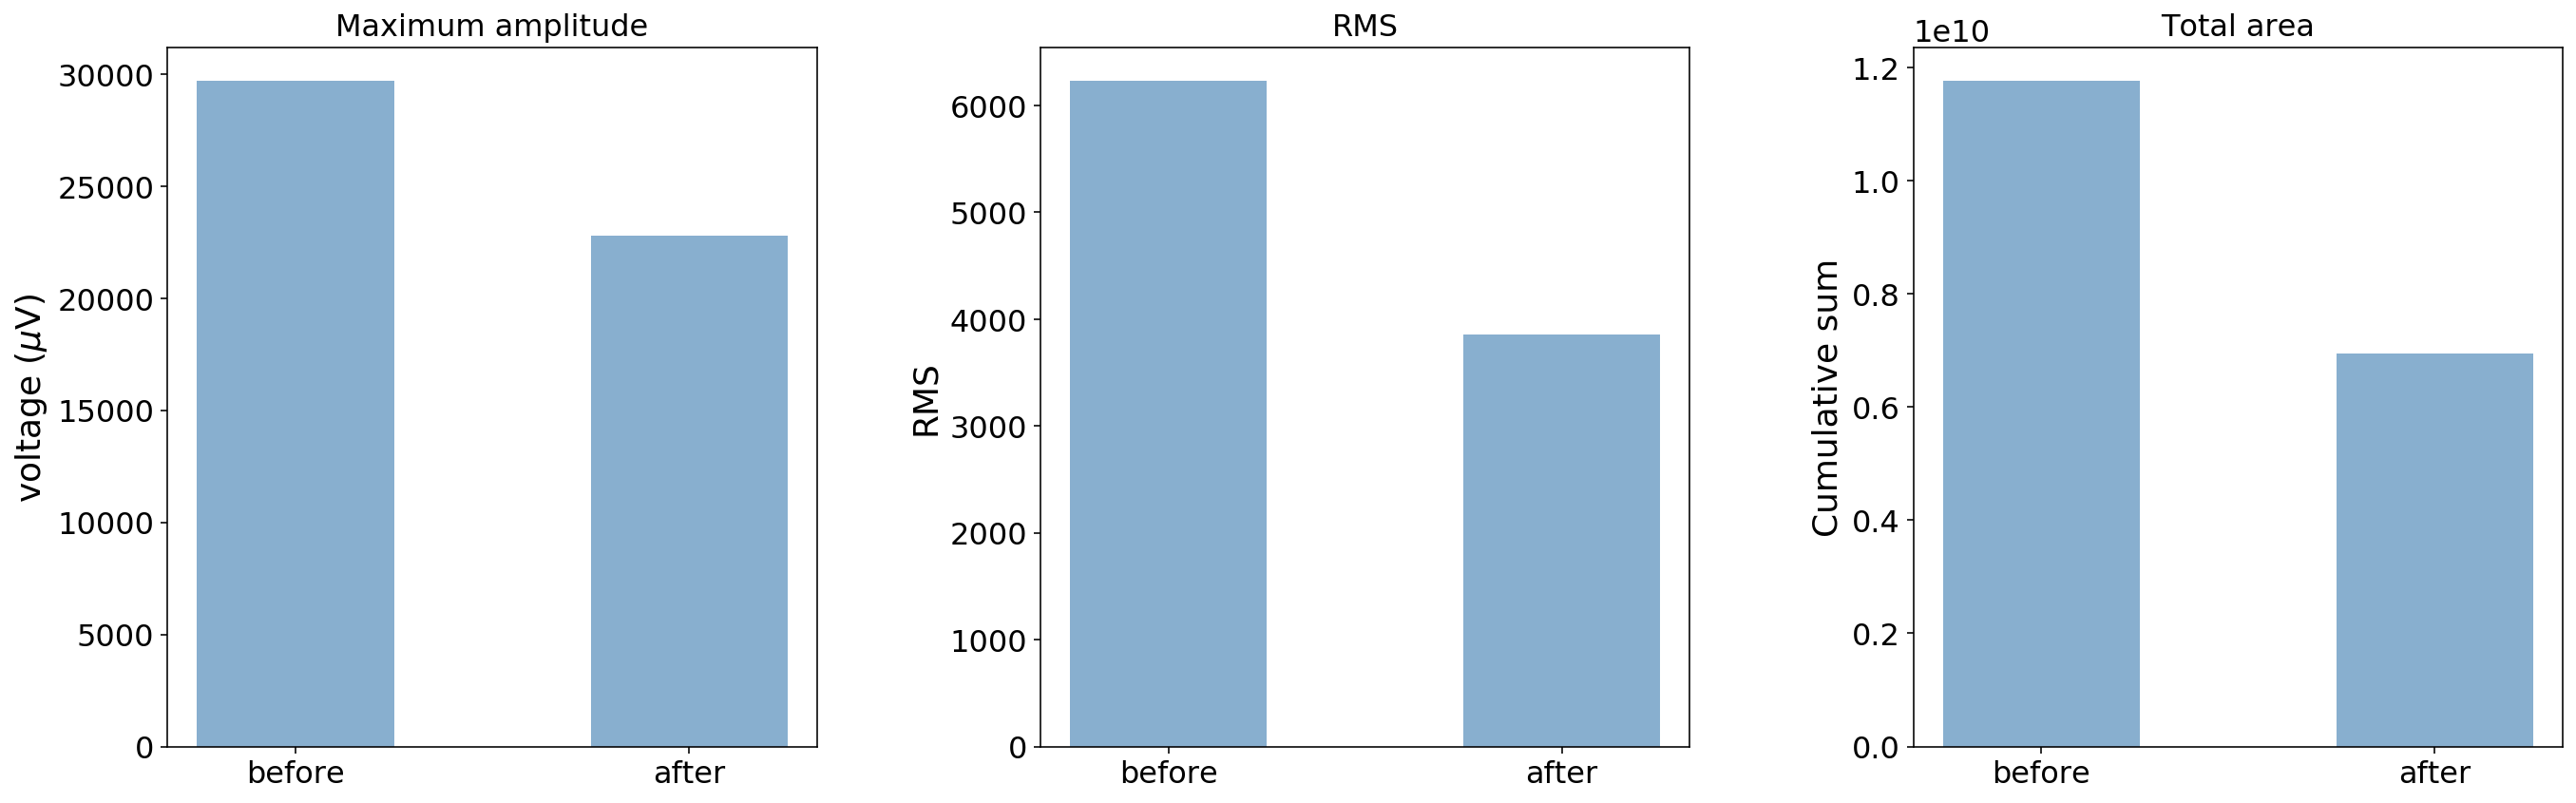

In [125]:
# set labels for each bar graph
labels = ('before','after')
y_pos = [0,1]

plt.figure(figsize=(20,7)) 

# plot and compare maximum amplitudes
plt.subplot(1, 3, 1)
for n in range(len(maxamps)):
    plt.bar(y_pos,maxamps,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Maximum amplitude',fontsize=16)
    plt.ylabel('voltage ($\mu$V)')

# plot and compare RMS
plt.subplot(1, 3, 2)
for n in range(len(rmss)):
    plt.bar(y_pos,rmss,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('RMS',fontsize=16)
    plt.ylabel('RMS')

# plot and compare total area
plt.subplot(1, 3, 3)
for n in range(len(maxsums)):
    plt.bar(y_pos,maxsums,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Total area',fontsize=16)
    plt.ylabel('Cumulative sum')

plt.tight_layout(pad=3.0)

We can see that for all three measures, there is a noticeable decrease when we compare the first to the last trial, indicating that the protocol of repeated contractions induced fatigue in the bicep muscle.

If we want to see how each measure changed over the entire protocol, we can run the analysis on all trials and plot the measures as functions of trial number. To do this, we first define functions that will pull all the file names from a given directory and sort the files for batch processing.

In [155]:
# loop over given directory to pull out file names
def loopFiles(path):
    trials=[]
    for filename in os.listdir(path):
        if filename.endswith(".wav"): 
            file=os.path.join(path,filename)
            trials.append(file)
    return(trials)

filelist = loopFiles('../data/S4/concentric/')

# sort files so analysis runs in order from trial 0 to trial 9
def lastchars(x):
    return(x[-5:])

dataset = sorted(filelist, key = lastchars)   

# print file names in order
for elem in dataset:
    print(elem)

../data/S4/concentric/S4_EMG_concentric_trial0.wav
../data/S4/concentric/S4_EMG_concentric_trial1.wav
../data/S4/concentric/S4_EMG_concentric_trial2.wav
../data/S4/concentric/S4_EMG_concentric_trial3.wav
../data/S4/concentric/S4_EMG_concentric_trial4.wav
../data/S4/concentric/S4_EMG_concentric_trial5.wav
../data/S4/concentric/S4_EMG_concentric_trial6.wav
../data/S4/concentric/S4_EMG_concentric_trial7.wav
../data/S4/concentric/S4_EMG_concentric_trial8.wav
../data/S4/concentric/S4_EMG_concentric_trial9.wav


In [169]:
def batch(files):
    # create an empty array to store data
    data = []
    # iterate over each recording to analyze and graph
    for record in files:
        xx=processEMG(record,graph=0)
        data.append(xx)
    # create empty arrays to hold measures
    maxsums = []
    maxamps = []
    rmss = []
    # for loop to iterate over recordings
    for n in range(len(data)):
        # calculate the maximum amplitude 
        maxamp=max(data[n]['absSignal'])
        maxamps.append(maxamp)
        # calculate the cumulative sum 
        sumSignal = np.cumsum(data[n]['absSignal'])
        # calculate the max of the cumulative sum, i.e. the total area
        maxsum = max(sumSignal)
        maxsums.append(maxsum)
        # calculate RMS
        rms=np.sqrt(np.mean(data[n]['absSignal']**2))
        rmss.append(rms)
        
    # plot and compare measures over all trials
    plt.figure(figsize=(20,7)) 

    # plot maximum amplitudes 
    plt.subplot(1, 3, 1)
    plt.plot(maxamps,'o-')
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('trial')
    plt.title('Maximum amplitude')

    # plot RMS
    plt.subplot(1, 3, 2)
    plt.plot(rmss,'o-');
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('trial')
    plt.title('RMS')

    # plot total area
    plt.subplot(1, 3, 3)
    plt.plot(maxsums,'o-')
    plt.xticks(np.arange(0, 10, step=1))
    plt.xlabel('trial')
    plt.title('Total area')

    plt.tight_layout(pad=3.0)
 
    return

Now we can run analysis on any subject just by changing the directory (S1, S2, etc.)

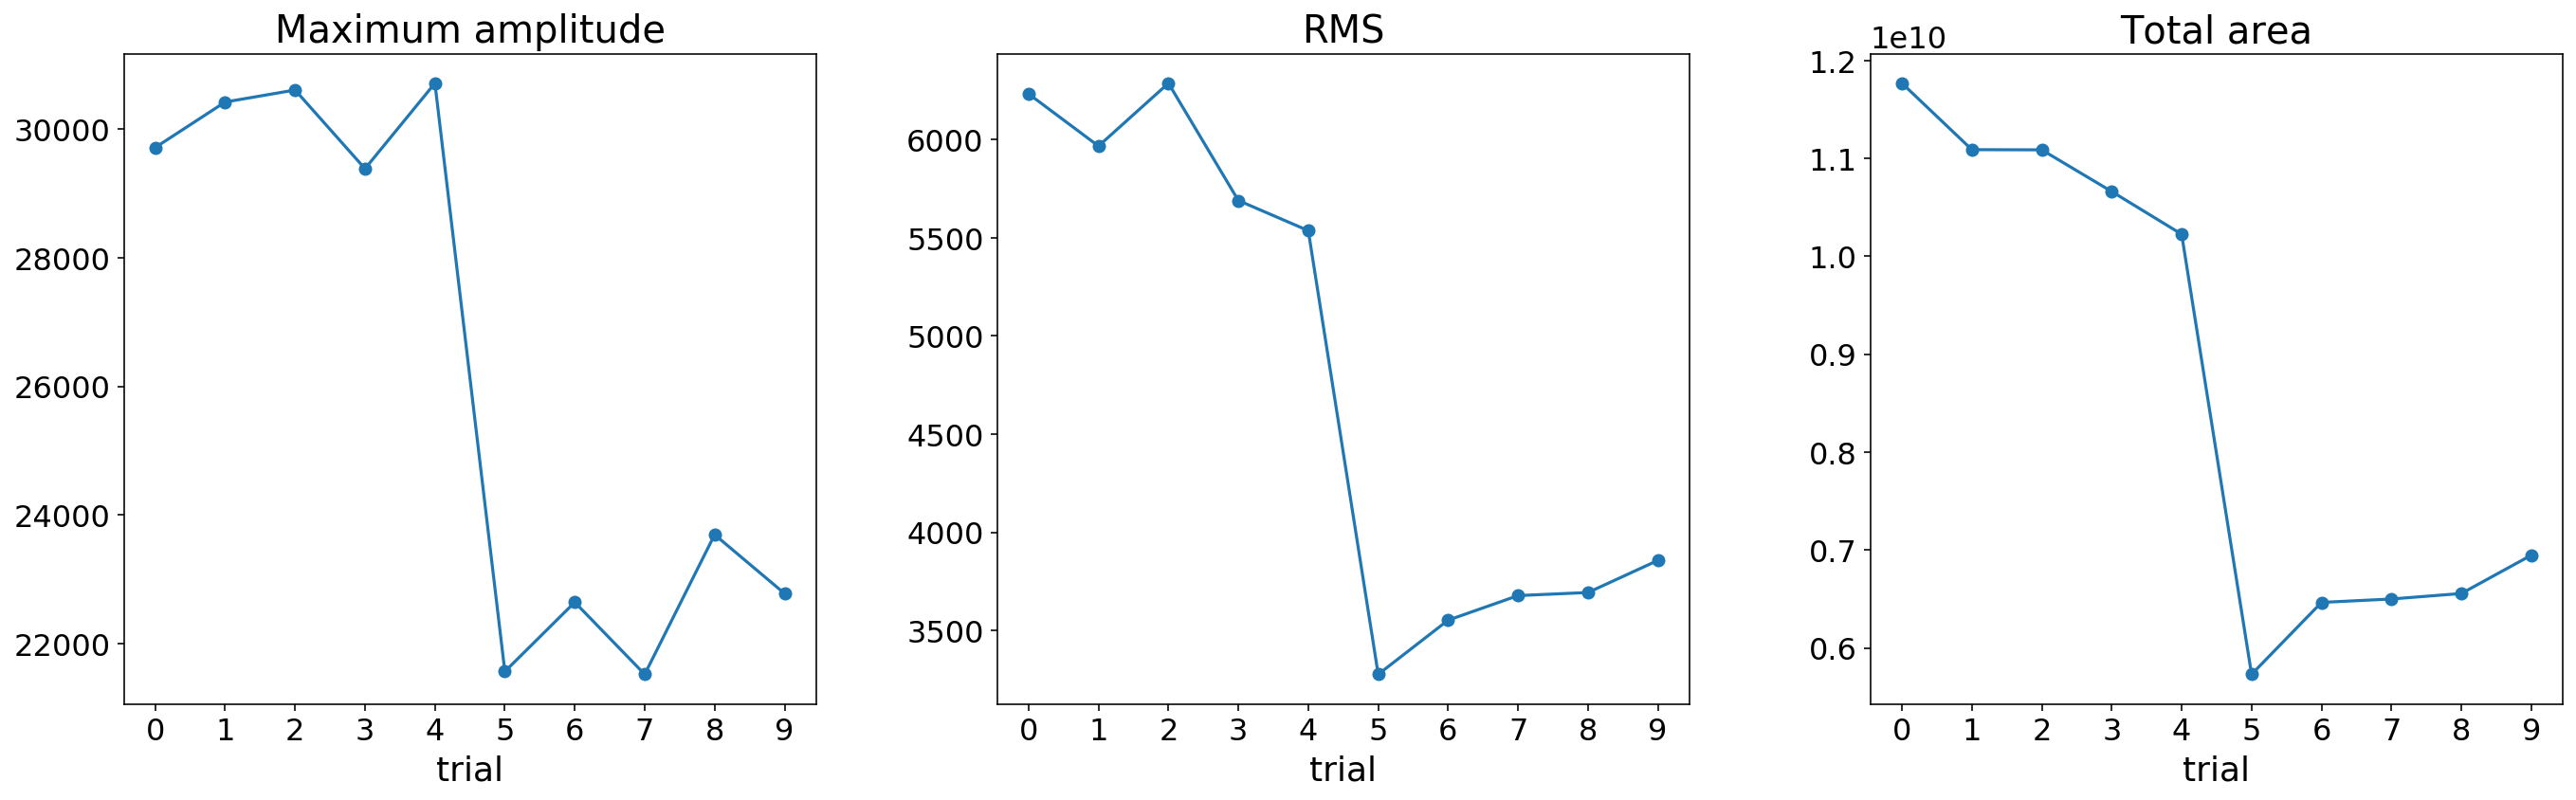

In [179]:
filelist = loopFiles('../data/S3/concentric/')
dataset = sorted(filelist, key = lastchars)
batch(files=dataset) 

We can also run frequency analysis on multiple files.

In [225]:
filelist = loopFiles('../data/S3/concentric/')
dataset = sorted(filelist, key = lastchars)

# create an empty array to store data
data = []
# iterate over each recording to analyze and graph
for record in dataset:
    xx=processEMG(record,graph=0)
    data.append(xx)
    
# create empty array to hold measures
MDFs = []
# for loop to iterate over recordings
for n in range(len(data)):
    ovData = windows(data[n]['dataf'],data[n]['sampleRate'],data[n]['sampleRate'])
    MDF = list(map(medianPF,ovData))
    MDFs.append(MDF)

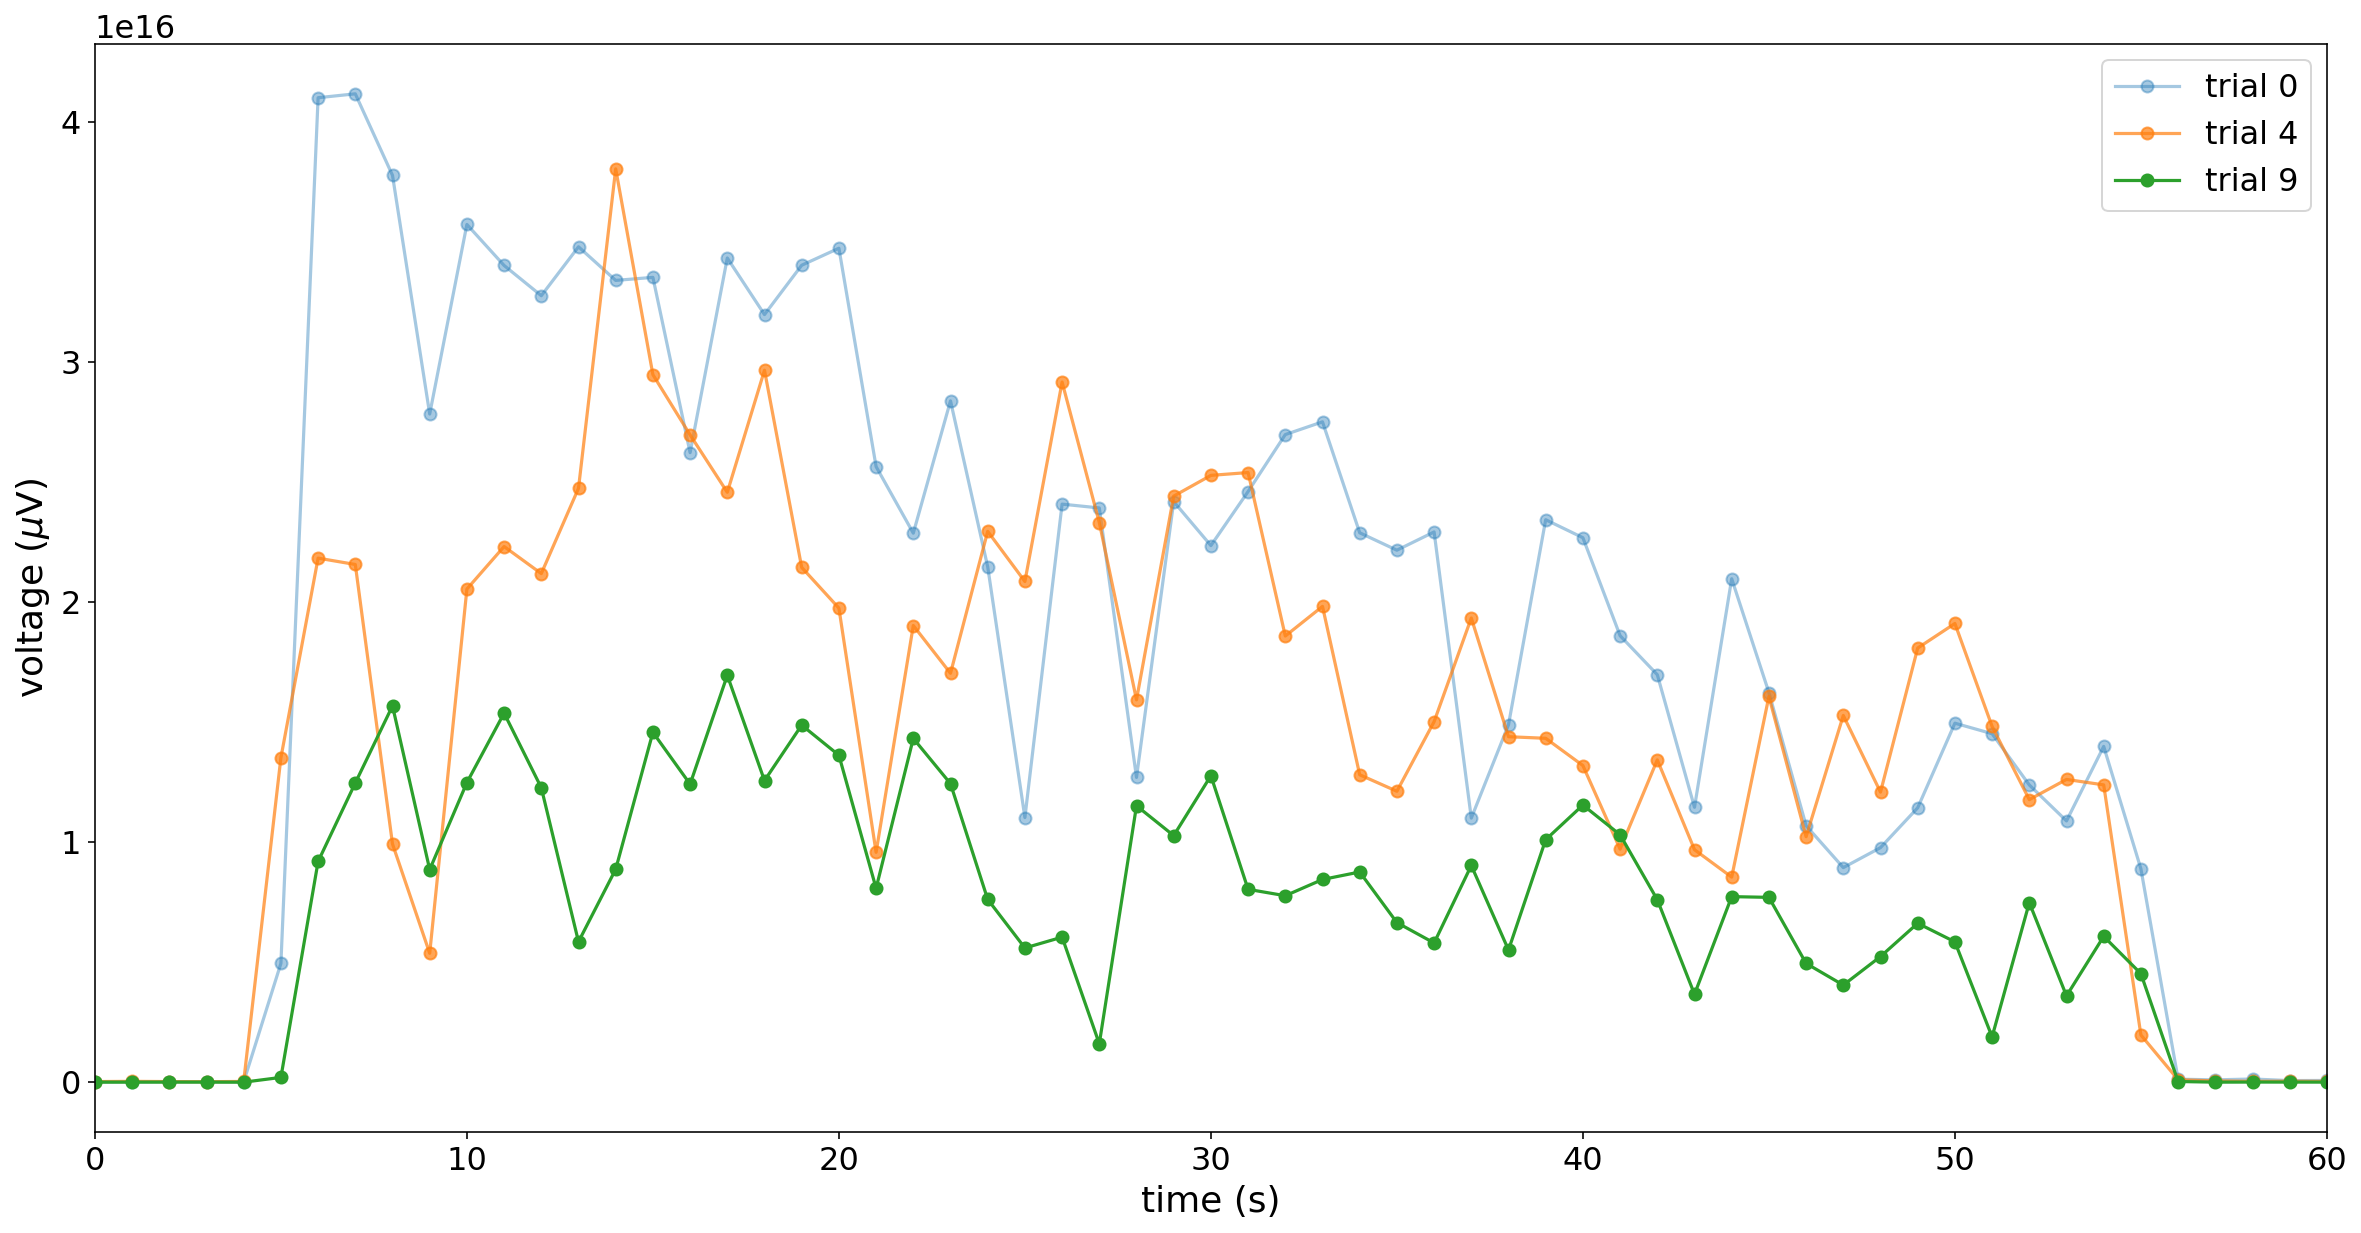

In [240]:
plt.figure(figsize=(20,10))
plt.plot(MDFs[0],'o-',label='trial 0',alpha=0.4)
plt.plot(MDFs[4],'o-',label='trial 4',alpha=0.7)
plt.plot(MDFs[9],'o-',label='trial 9')
plt.xlabel('time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(0,60)
plt.legend();

In [254]:
# suppress tight layout warning
import warnings
warnings.filterwarnings('ignore')

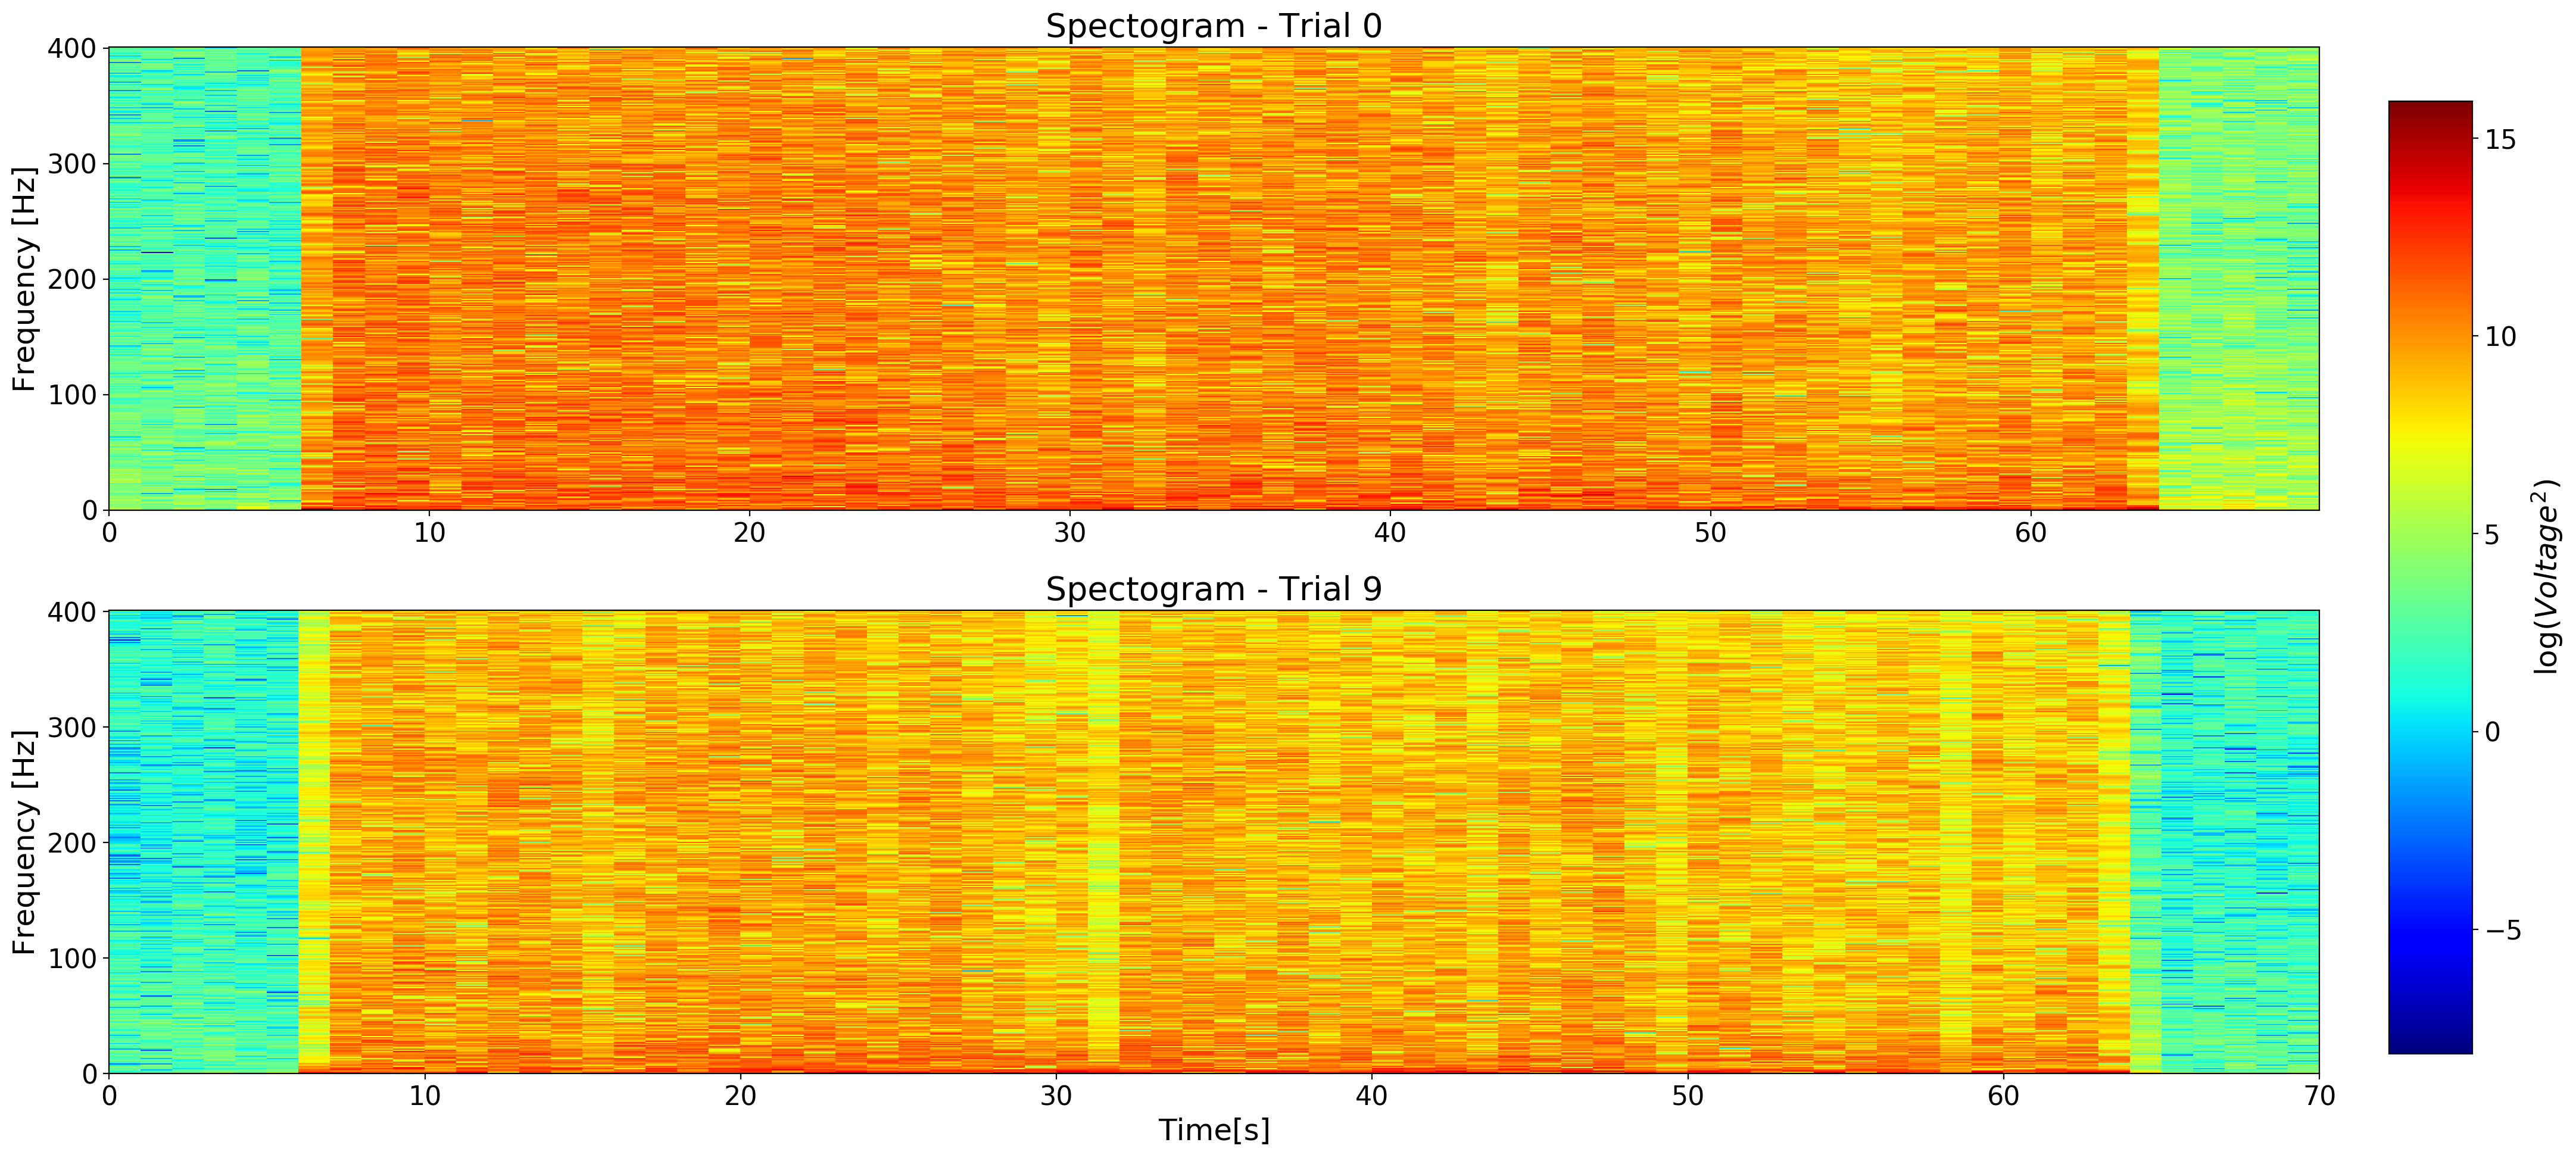

In [255]:
trial0=processEMG(file='../data/S3/concentric/S3_EMG_concentric_trial0.wav',graph=0)
trial9=processEMG(file='../data/S3/concentric/S3_EMG_concentric_trial9.wav',graph=0)

fig = plt.figure(figsize=(20,10),dpi=100)

data = trial0['absSignal']
f, t, sxx1 = sc.signal.spectrogram(data,trial0['sampleRate'],nperseg=trial0['sampleRate'],\
                                   scaling='spectrum')
f = f[:401]
sxx1 = sxx1[:401]
min_sxx1 = np.min(np.log(sxx1))
max_sxx1 = np.max(np.log(sxx1))

plt.subplot(211)
plt.pcolormesh(np.log(sxx1),cmap='jet',vmin=min_sxx1,vmax=max_sxx1)
plt.ylabel('Frequency [Hz]')
plt.title('Spectogram - Trial 0')

data = trial9['absSignal']
f, t, sxx = sc.signal.spectrogram(data,trial9['sampleRate'],nperseg=trial9['sampleRate'],\
                                  scaling='spectrum')
f = f[:401]
sxx = sxx[:401]
plt.subplot(212)
plt.pcolormesh(np.log(sxx),cmap='jet',vmin=min_sxx1,vmax=max_sxx1)
plt.ylabel('Frequency [Hz]')
plt.title('Spectogram - Trial 9')

plt.xlabel('Time[s]')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, .1, 0.035, 0.8])
plt.colorbar(label='log($Voltage^2$)',cax=cbar_ax,)

plt.draw()
plt.tight_layout()

From the above figures, we can see that the first spectogram reaches higher values associated with the power content per frequency (orange area). This can be observed along the whole frequency band (0-400 Hz). The second spectogram shows a generalized decrease in the power content contributed by frequency. It is possibble to quickly compare these graphs by noticing the difference in the overall colors of the spectogram, with the first spectogram showing tones closer to red (higher power values), while the second one displays an overall yellow color (lower power values)  